<a href="https://colab.research.google.com/github/AbhiramGude/Redevelopment-of-Rabindra-Sadan-Complex/blob/main/Rabindra_Sadan_Sentimental_Anlaysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentimental Analysis of Rabindra Sadan Complex

For a proposal for the redevelopment of the Rabindra Sadan Complex, we have gathered people's perceptions using available Google Maps reviews and studied how people have experienced the space from an architectural perspective.

## Data Collection

In [2]:
import pandas as pd
import glob
import os

path = r"/content/"
files = glob.glob(os.path.join(path, "*.xlsx"))

print("Files found:", files)
dfs = [pd.read_excel(f) for f in files]
reviews_df = pd.concat(dfs, ignore_index=True)
print("Data Info")
print(reviews_df.info())

print("\n Missing Values")
print(reviews_df.isnull().sum())

Files found: ['/content/Nandan.xlsx', '/content/Paschim Banga Natya Akademi.xlsx', '/content/Charukala Bhavan.xlsx', '/content/Nandan Area.xlsx', '/content/Kolkata Information Centre.xlsx', '/content/Sisir Mancha.xlsx', '/content/Academy of Fine Arts.xlsx', "/content/Raju's Kitchen.xlsx", '/content/Gaganendra Shilpa.xlsx', '/content/Rabindra Sadan.xlsx', '/content/Sainik Bhawan.xlsx']
Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9464 entries, 0 to 9463
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      9464 non-null   object
 1   url        9464 non-null   object
 2   stars      9464 non-null   int64 
 3   name       9464 non-null   object
 4   reviewUrl  9464 non-null   object
 5   text       7606 non-null   object
dtypes: int64(1), object(5)
memory usage: 443.8+ KB
None

 Missing Values
title           0
url             0
stars           0
name            0
reviewUrl       0
text         1858
dt

## Data Preprocessing

In [3]:
reviews_df = reviews_df.dropna(subset=["text"])
reviews_df = reviews_df.drop(columns=["url","reviewUrl","name"])
unique_titles = reviews_df["title"].unique()
print("Number of Unique Titles:", len(unique_titles))

print("\nNumber of Reviews per Space : ")
for t in unique_titles:
    reviews_count = reviews_df[reviews_df["title"] == t].shape[0]
    print(f"{t}: {reviews_count}")

Number of Unique Titles: 11

Number of Reviews per Space : 
Nandan: 2998
Paschim Banga Natya Akademi: 17
Rajya Charukala Parshad - Charukala Bhavan: 25
Nandan Area: 34
Kolkata Information Centre: 25
Sisir Mancha: 388
Academy of Fine Arts: 788
Raju's Kitchen: 155
Gaganendra Shilpa Pradarshashala: 175
Rabindra Sadan: 2987
Sainik Bhawan ZILA SAINIK BOARD KOLKATA: 14


In [4]:
!pip install translate

In [5]:
## Translation from Bengali Text to English

from translate import Translator

translator = Translator(to_lang="en")

def translate_text(text):
    try:
        # Check if the text is likely Bengali (this is a simple check and might not be perfect)
        # A more robust approach might involve language detection
        if isinstance(text, str) and any('\u0980' <= char <= '\u09FF' for char in text): # Check for Bengali Unicode range and if it's a string
            return translator.translate(text)
        else:
            return text # Return original text if not likely Bengali
    except Exception as e:
        print(f"Translation error: {e}")
        return text # Return original text in case of error


# Apply translation to the 'text' column
# This might take some time depending on the number of reviews
reviews_df['translated_text'] = reviews_df['text'].apply(translate_text)

# Display rows where translation occurred
translated_rows = reviews_df[reviews_df['text'] != reviews_df['translated_text']]
display(translated_rows[['text', 'translated_text']].head())

Empty DataFrame
Columns: [text, translated_text]
Index: []

In [6]:
# Select and rename relevant columns
# We are selecting 'title', 'stars', and the 'translated_text' column
sentiment_df = reviews_df[['title', 'stars', 'translated_text']].copy()

# Rename the columns as requested
sentiment_df.rename(columns={
    'title': 'space',
    'stars': 'stars',
    'translated_text': 'review' # Renaming the translated text column to 'review'
}, inplace=True)

# Drop rows where the 'review' column (translated text) is empty
sentiment_df.dropna(subset=['review'], inplace=True)
sentiment_df = sentiment_df[sentiment_df['review'].str.strip() != '']


# Display the new DataFrame
display(sentiment_df.head())

space  stars                                             review
0  Nandan      5  • Nandan is not just a cinema hall — it’s a cu...
1  Nandan      5  This is one the most beautiful cultural place ...
2  Nandan      5  A Cultural Gem in the Heart of Kolkata – Nanda...
3  Nandan      5  Nandan is a prominent cultural center located ...
4  Nandan      5  Nandan is the cultural heartbeat of Kolkata—a ...

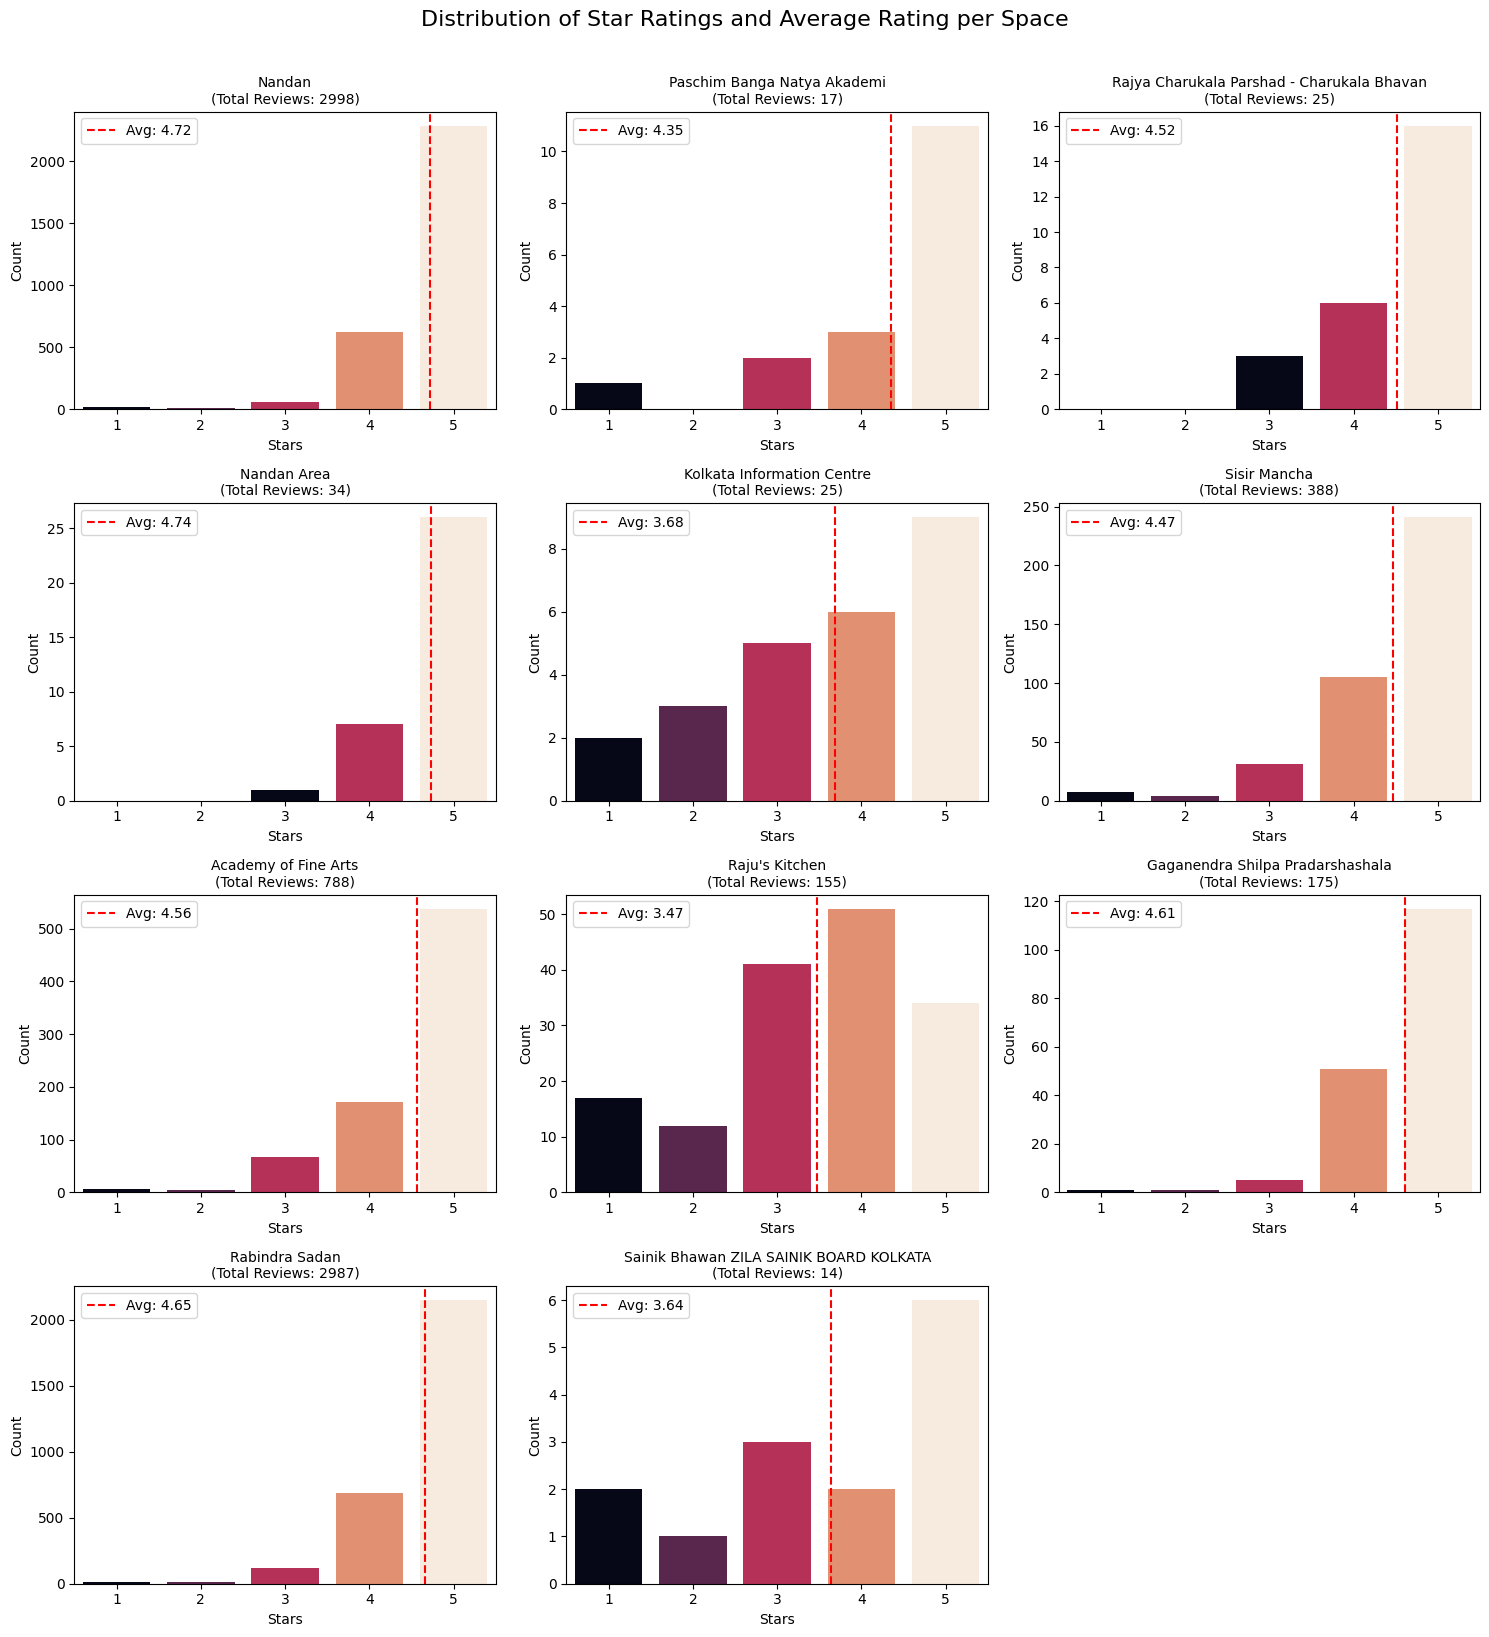

In [7]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

# Use the new sentiment_df
titles = sentiment_df["space"].unique() # Use 'space' column
n_titles = len(titles)
n_cols = 3
n_rows = math.ceil(n_titles / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

review_counts = {}  # to store review counts per title

for i, t in enumerate(titles):
    # Use the new sentiment_df and 'space' column
    subset = sentiment_df[sentiment_df["space"] == t] # Use 'space' column
    review_count = subset.shape[0]
    # Use the new 'stars' column
    avg_rating = subset["stars"].mean() # Use 'stars' column

    review_counts[t] = review_count  # save review count

    # Countplot of ratings using the new 'stars' column
    sns.countplot(
    data=subset,
    x="stars", # Use the new column name
    hue="stars",
    ax=axes[i],
    palette="rocket",
    order=[1, 2, 3, 4, 5],
    legend=False
     )
# Rating Line
    axes[i].axvline(avg_rating-1, color="red", linestyle="--", label=f"Avg: {avg_rating:.2f}")

    axes[i].set_title(f"{t}\n(Total Reviews: {review_count})", fontsize=10)
    axes[i].set_xlabel("Stars") # Keep label as Stars for clarity
    axes[i].set_ylabel("Count")
    axes[i].legend()

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of Star Ratings and Average Rating per Space", y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1.01])
plt.show()

## Sentimental Analysis

In [8]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 657.8 kB/s eta 0:00:00


In [9]:
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Download VADER lexicon (if you haven't already)
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get VADER sentiment scores
def get_vader_sentiment_scores(text):
    if not isinstance(text, str):
        return {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0} # Return neutral scores for non-string inputs
    # Apply VADER to the translated_text column (which retains punctuation)
    return analyzer.polarity_scores(text)

# Apply VADER to the 'review' column and create new columns for scores
sentiment_df['vader_scores'] = sentiment_df['review'].apply(get_vader_sentiment_scores)

# Extract compound score into a separate column
sentiment_df['vader_compound'] = sentiment_df['vader_scores'].apply(lambda x: x['compound'])

# Classify sentiment based on compound score
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

sentiment_df['vader_sentiment'] = sentiment_df['vader_compound'].apply(classify_sentiment)


# Display the first few rows with sentiment scores
display(sentiment_df[['review', 'vader_scores', 'vader_compound', 'vader_sentiment']])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


review  \
0     • Nandan is not just a cinema hall — it’s a cu...   
1     This is one the most beautiful cultural place ...   
2     A Cultural Gem in the Heart of Kolkata – Nanda...   
3     Nandan is a prominent cultural center located ...   
4     Nandan is the cultural heartbeat of Kolkata—a ...   
...                                                 ...   
9443                                Near rabindra sadan   
9444                                 Ex Soldiers office   
9445                                      Helpful stuff   
9446            Kisi ke pass yaha ka contact no hai kya   
9447                                         Nicevplace   

                                           vader_scores  vader_compound  \
0     {'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'comp...          0.9975   
1     {'neg': 0.01, 'neu': 0.884, 'pos': 0.106, 'com...          0.9459   
2     {'neg': 0.0, 'neu': 0.706, 'pos': 0.294, 'comp...          0.9989   
3     {'neg': 0.0, 'neu': 0.789, 'pos': 0.211, 'comp...          0.9926   
4     {'neg': 0.0, 'neu': 0.636, 'pos': 0.364, 'comp...          0.9612   
...                                                 ...             ...   
9443  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...          0.0000   
9444  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...          0.0000   
9445  {'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'comp...          0.4215   
9446  {'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...         -0.2960   
9447  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...          0.0000   

     vader_sentiment  
0           Positive  
1           Positive  
2           Positive  
3           Positive  
4           Positive  
...              ...  
9443         Neutral  
9444         Neutral  
9445        Positive  
9446        Negative  
9447         Neutral  

[7606 rows x 4 columns]

In [10]:
!pip install transformers torch

In [11]:
import torch
from transformers import pipeline
import pandas as pd

# Check if a GPU is available and use it
device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU' if device == 0 else 'CPU'}")

# Load a pre-trained sentiment analysis pipeline
# 'sentiment-analysis' uses a fine-tuned model like 'distilbert-base-uncased-finetuned-sst-2-english' by default
# Specify truncation=True in the pipeline call to handle long sequences
sentiment_pipeline = pipeline("sentiment-analysis", device=device, truncation=True)


# Function to get BERT sentiment prediction
def get_bert_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return {'label': 'Neutral', 'score': 0.0} # Handle non-string or empty input

    # The pipeline returns a list of dicts, e.g., [{'label': 'POSITIVE', 'score': 0.9998}]
    # The pipeline is now initialized with truncation=True, so it handles long texts internally
    result = sentiment_pipeline(text)[0]
    return result

# Apply BERT sentiment analysis to the 'review' column
# This might take a significant amount of time depending on the number of reviews and hardware
print("Performing BERT sentiment analysis... This might take a while.")
sentiment_df['bert_sentiment_raw'] = sentiment_df['review'].apply(get_bert_sentiment)

# Extract label and score into separate columns for easier use
sentiment_df['bert_sentiment_label'] = sentiment_df['bert_sentiment_raw'].apply(lambda x: x['label'])
sentiment_df['bert_sentiment_score'] = sentiment_df['bert_sentiment_raw'].apply(lambda x: x['score'])


# Display the first few rows with BERT sentiment results
display(sentiment_df[['review', 'bert_sentiment_label', 'bert_sentiment_score']].head())

# Display counts per sentiment label
print("\nBERT Sentiment Distribution:")
print(sentiment_df['bert_sentiment_label'].value_counts())

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Using device: CPU


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


Performing BERT sentiment analysis... This might take a while.


review bert_sentiment_label  \
0  • Nandan is not just a cinema hall — it’s a cu...             POSITIVE   
1  This is one the most beautiful cultural place ...             POSITIVE   
2  A Cultural Gem in the Heart of Kolkata – Nanda...             POSITIVE   
3  Nandan is a prominent cultural center located ...             POSITIVE   
4  Nandan is the cultural heartbeat of Kolkata—a ...             POSITIVE   

   bert_sentiment_score  
0              0.999785  
1              0.975507  
2              0.999857  
3              0.999766  
4              0.999848


BERT Sentiment Distribution:
bert_sentiment_label
POSITIVE    6902
NEGATIVE     704
Name: count, dtype: int64


In [12]:
# Display counts per sentiment label for VADER
print("VADER Sentiment Distribution:")
display(sentiment_df['vader_sentiment'].value_counts())

print("\n") # Add a newline for better separation

# Display counts per sentiment label for BERT
print("BERT Sentiment Distribution:")
display(sentiment_df['bert_sentiment_label'].value_counts())

VADER Sentiment Distribution:


vader_sentiment
Positive    6400
Neutral      980
Negative     226
Name: count, dtype: int64



BERT Sentiment Distribution:


bert_sentiment_label
POSITIVE    6902
NEGATIVE     704
Name: count, dtype: int64

In [13]:
# Create the final DataFrame with selected and renamed columns
final_sentiment_df = sentiment_df[['space', 'stars', 'review', 'bert_sentiment_score', 'bert_sentiment_label']].copy()

# Rename the columns as requested
final_sentiment_df.rename(columns={
    'space': 'location',
    'stars': 'stars',
    'review': 'review',
    'bert_sentiment_score': 'sentiment score',
    'bert_sentiment_label': 'sentiment (bert)'
}, inplace=True)

# Display the final DataFrame
print("Final DataFrame for Sentiment Analysis Results:")
display(final_sentiment_df)

# Display the total number of rows in the final DataFrame
print(f"\nTotal number of reviews in the final DataFrame: {final_sentiment_df.shape[0]}")

Final DataFrame for Sentiment Analysis Results:


location  stars  \
0                                      Nandan      5   
1                                      Nandan      5   
2                                      Nandan      5   
3                                      Nandan      5   
4                                      Nandan      5   
...                                       ...    ...   
9443  Sainik Bhawan ZILA SAINIK BOARD KOLKATA      5   
9444  Sainik Bhawan ZILA SAINIK BOARD KOLKATA      4   
9445  Sainik Bhawan ZILA SAINIK BOARD KOLKATA      4   
9446  Sainik Bhawan ZILA SAINIK BOARD KOLKATA      1   
9447  Sainik Bhawan ZILA SAINIK BOARD KOLKATA      5   

                                                 review  sentiment score  \
0     • Nandan is not just a cinema hall — it’s a cu...         0.999785   
1     This is one the most beautiful cultural place ...         0.975507   
2     A Cultural Gem in the Heart of Kolkata – Nanda...         0.999857   
3     Nandan is a prominent cultural center located ...         0.999766   
4     Nandan is the cultural heartbeat of Kolkata—a ...         0.999848   
...                                                 ...              ...   
9443                                Near rabindra sadan         0.945785   
9444                                 Ex Soldiers office         0.967052   
9445                                      Helpful stuff         0.999722   
9446            Kisi ke pass yaha ka contact no hai kya         0.981856   
9447                                         Nicevplace         0.999779   

     sentiment (bert)  
0            POSITIVE  
1            POSITIVE  
2            POSITIVE  
3            POSITIVE  
4            POSITIVE  
...               ...  
9443         POSITIVE  
9444         NEGATIVE  
9445         POSITIVE  
9446         NEGATIVE  
9447         POSITIVE  

[7606 rows x 5 columns]


Total number of reviews in the final DataFrame: 7606


In [15]:
from google.colab import auth
auth.authenticate_user()

In [19]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=final_sentiment_df)

https://docs.google.com/spreadsheets/d/1PKCccMyW9trW8LCxmW2KPT3K9DxJ0EiG2wcUUfBFGow/edit#gid=0


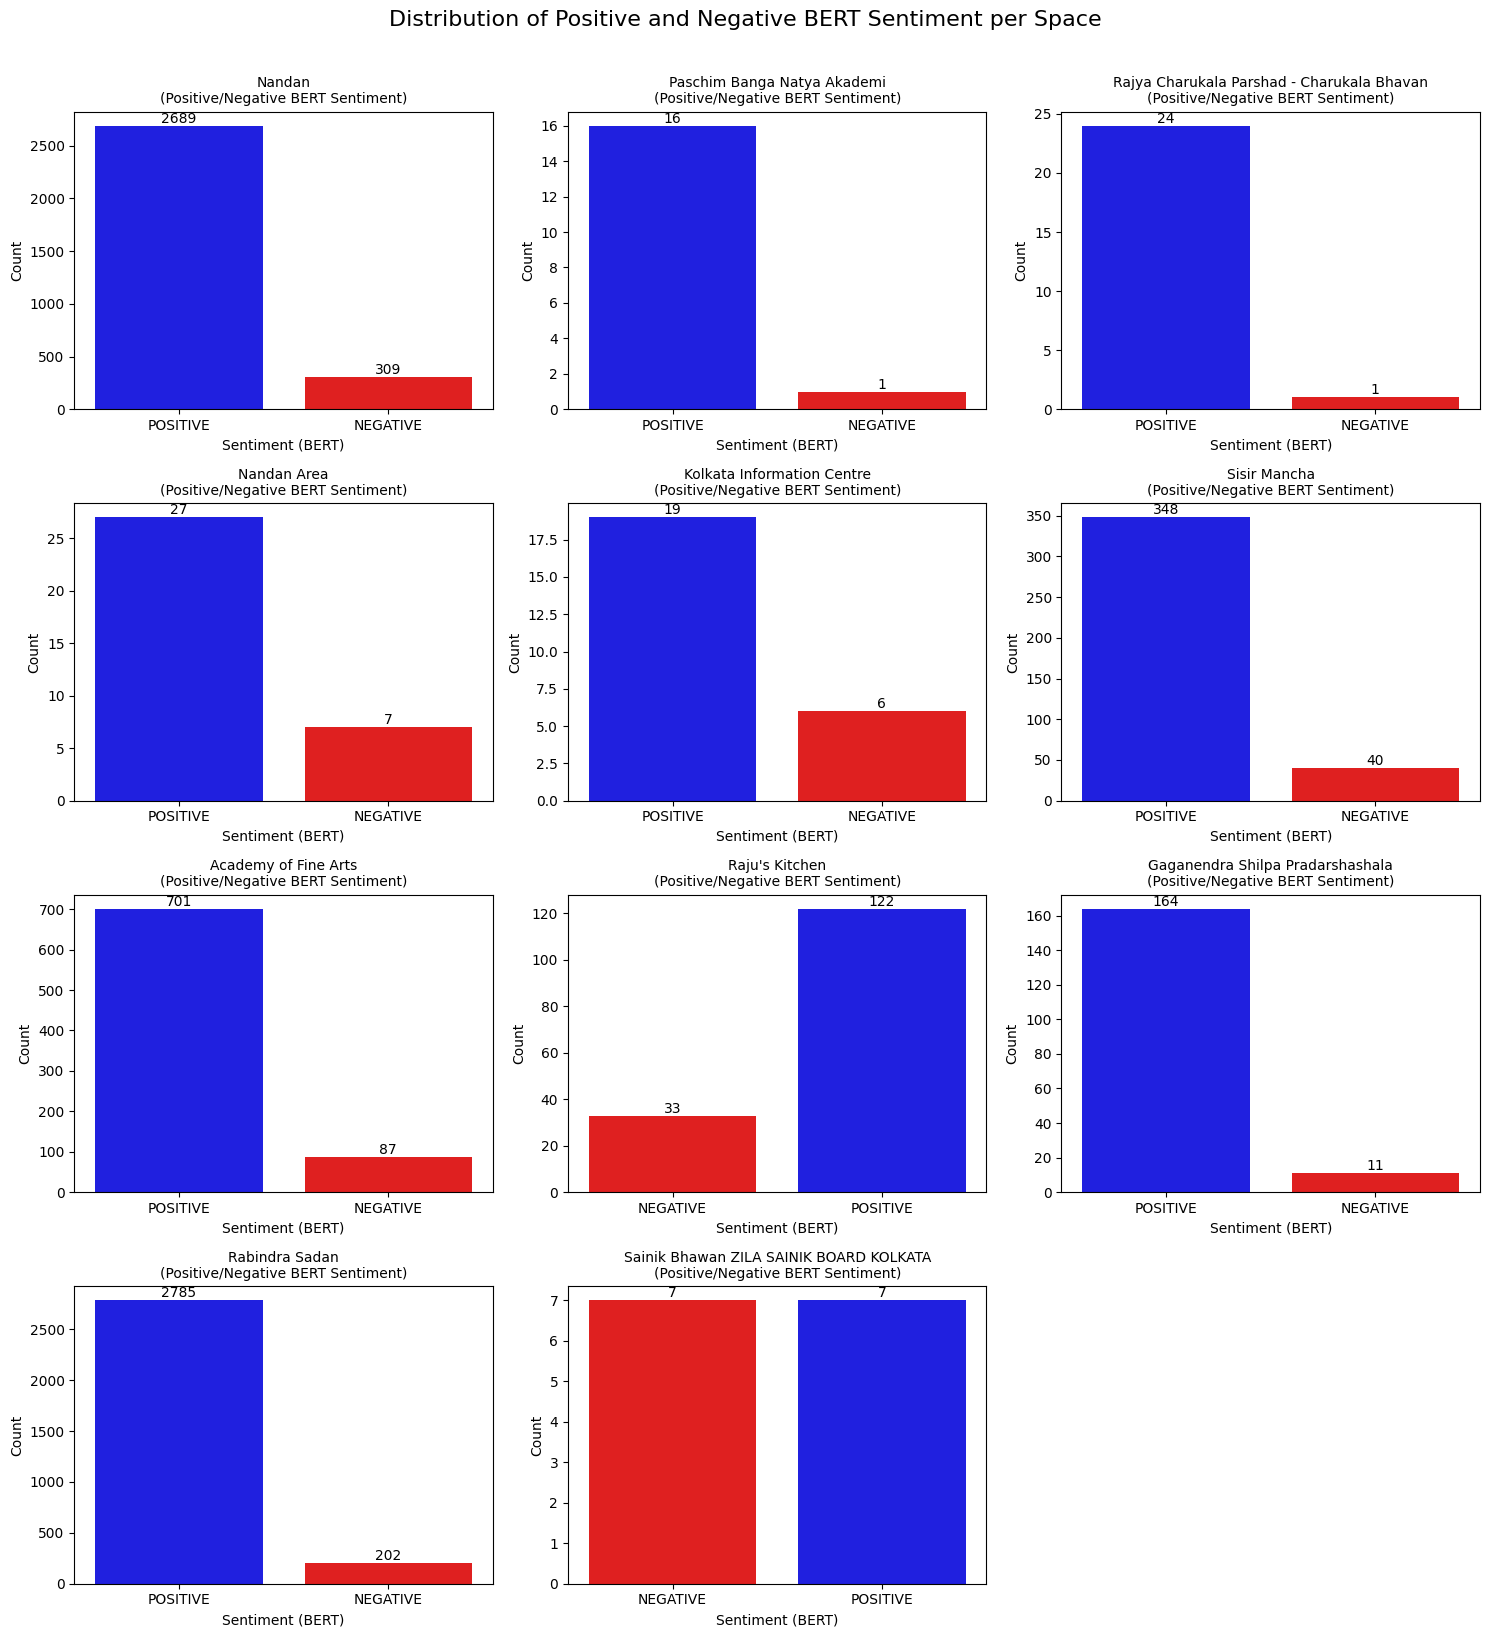

In [20]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

# Use the final_sentiment_df with BERT results
spaces = final_sentiment_df["location"].unique()
n_spaces = len(spaces)
n_cols = 3
n_rows = math.ceil(n_spaces / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, space in enumerate(spaces):
    # Filter for the current space
    subset = final_sentiment_df[final_sentiment_df["location"] == space]

    # Filter for Positive and Negative sentiment
    sentiment_subset = subset[subset['sentiment (bert)'].isin(['POSITIVE', 'NEGATIVE'])]

    # Countplot of Positive and Negative sentiment
    sns.countplot(
        data=sentiment_subset,
        x='sentiment (bert)', # Use the BERT sentiment label column
        hue='sentiment (bert)',
        ax=axes[i],
        palette={'POSITIVE': 'blue', 'NEGATIVE': 'red'}, # Use distinct colors
        legend=False
    )

    axes[i].set_title(f"{space}\n(Positive/Negative BERT Sentiment)", fontsize=10)
    axes[i].set_xlabel("Sentiment (BERT)")
    axes[i].set_ylabel("Count")
    # Add counts on top of bars
    for container in axes[i].containers:
        axes[i].bar_label(container)


# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of Positive and Negative BERT Sentiment per Space", y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1.01])
plt.show()

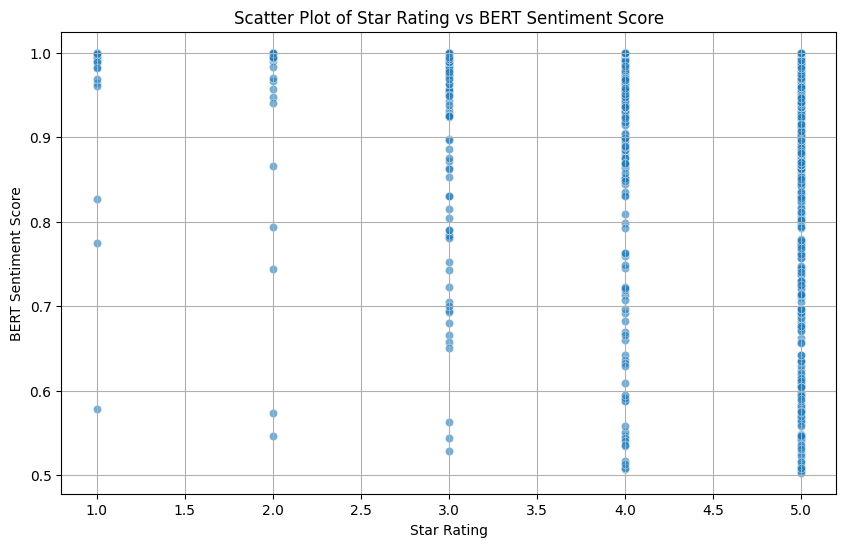

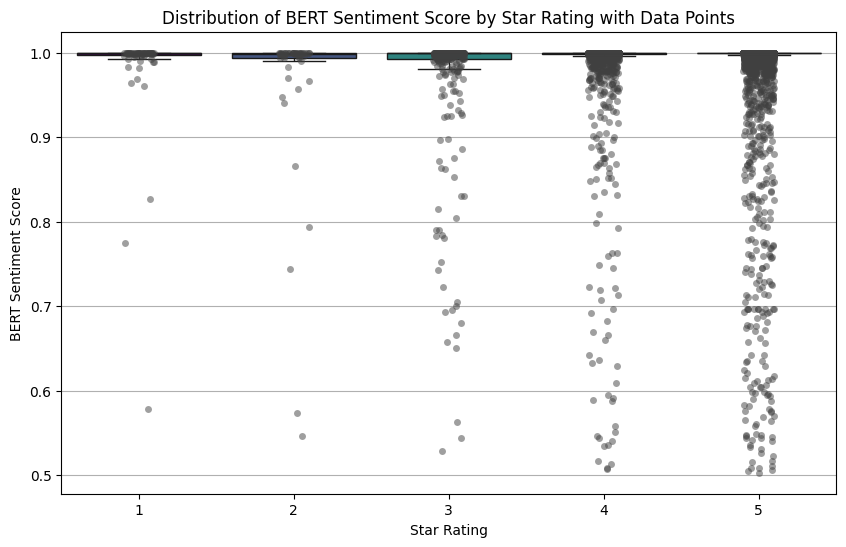

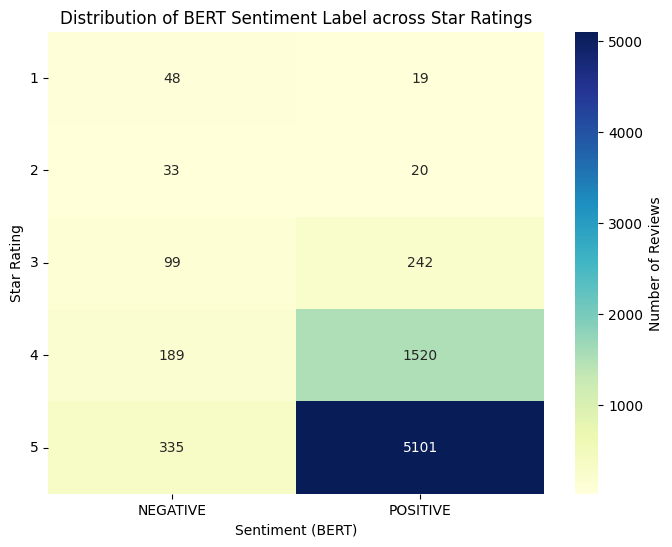

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Import pandas if not already imported

# Create a scatter plot of Stars vs Sentiment Score
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_sentiment_df, x='stars', y='sentiment score', alpha=0.6)
plt.title('Scatter Plot of Star Rating vs BERT Sentiment Score')
plt.xlabel('Star Rating')
plt.ylabel('BERT Sentiment Score')
plt.grid(True)
plt.show()

# Create a box plot of BERT sentiment score vs. Star Rating
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_sentiment_df, x='stars', y='sentiment score', palette='viridis', showfliers=False, hue='stars', legend=False) # Added hue='stars' and legend=False
sns.stripplot(data=final_sentiment_df, x='stars', y='sentiment score', color=".25", alpha=0.5, jitter=True) # Add a stripplot to show individual points
plt.title('Distribution of BERT Sentiment Score by Star Rating with Data Points')
plt.xlabel('Star Rating')
plt.ylabel('BERT Sentiment Score')
plt.grid(axis='y')
plt.show()

# Create a cross-tabulation of Star Rating and BERT Sentiment Label
# We only consider POSITIVE and NEGATIVE for the heatmap as requested in previous plots
sentiment_counts = final_sentiment_df[final_sentiment_df['sentiment (bert)'].isin(['POSITIVE', 'NEGATIVE'])].groupby(['stars', 'sentiment (bert)']).size().unstack(fill_value=0)

# Ensure all star ratings 1-5 are present, even if no reviews have sentiment
all_stars = pd.DataFrame(index=range(1, 6))
sentiment_counts = all_stars.join(sentiment_counts, how='left').fillna(0)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(sentiment_counts, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Number of Reviews'})
plt.title('Distribution of BERT Sentiment Label across Star Ratings')
plt.xlabel('Sentiment (BERT)')
plt.ylabel('Star Rating')
plt.yticks(rotation=0) # Keep star ratings horizontal
plt.show()

In [25]:
# Filter for 1-star reviews classified as POSITIVE by BERT
one_star_positive = final_sentiment_df[(final_sentiment_df['stars'] == 1) & (final_sentiment_df['sentiment (bert)'] == 'POSITIVE')]

# Filter for 5-star reviews classified as NEGATIVE by BERT
five_star_negative = final_sentiment_df[(final_sentiment_df['stars'] == 5) & (final_sentiment_df['sentiment (bert)'] == 'NEGATIVE')]

In [26]:
print("Reviews with 1 Star Rating but Positive BERT Sentiment:")
display(one_star_positive[['location', 'stars', 'review', 'sentiment (bert)', 'sentiment score']])

Reviews with 1 Star Rating but Positive BERT Sentiment:


location  stars  \
1272                       Nandan      1   
1354                       Nandan      1   
1854                       Nandan      1   
2585                       Nandan      1   
2738                       Nandan      1   
2902                       Nandan      1   
3015  Paschim Banga Natya Akademi      1   
3175   Kolkata Information Centre      1   
3494                 Sisir Mancha      1   
3558                 Sisir Mancha      1   
3601                 Sisir Mancha      1   
3854         Academy of Fine Arts      1   
4348         Academy of Fine Arts      1   
4710         Academy of Fine Arts      1   
5811               Raju's Kitchen      1   
7592               Rabindra Sadan      1   
7857               Rabindra Sadan      1   
9012               Rabindra Sadan      1   
9118               Rabindra Sadan      1   

                                                 review sentiment (bert)  \
1272  Been to Nandan several times. Recently went to...         POSITIVE   
1354  Disgusting behaviour from the guard. But u can...         POSITIVE   
1854  Very nice place for meeting with friend and ph...         POSITIVE   
2585  Though it is basically a cinema hall but can c...         POSITIVE   
2738  It is a cinema hall situated in the back side ...         POSITIVE   
2902                           Best place to spend time         POSITIVE   
3015                                               Fine         POSITIVE   
3175             All Official Information You can Have.         POSITIVE   
3494                                        Car parking         POSITIVE   
3558                                               Good         POSITIVE   
3601                                               ভালো         POSITIVE   
3854  Excellent place in Kolkata for stage Drama /Th...         POSITIVE   
4348                                    Wonderful place         POSITIVE   
4710  It's a great place  of work and worship  for a...         POSITIVE   
5811                                      Arogant owner         POSITIVE   
7592  Very popular...\nToo crowded...\nDidn't like t...         POSITIVE   
7857                                               Nice         POSITIVE   
9012                Grest place for cultural activities         POSITIVE   
9118                  It's a cultural place of our city         POSITIVE   

      sentiment score  
1272         0.997507  
1354         0.964198  
1854         0.999841  
2585         0.996752  
2738         0.998024  
2902         0.995722  
3015         0.999834  
3175         0.996602  
3494         0.992904  
3558         0.999816  
3601         0.774952  
3854         0.999857  
4348         0.999883  
4710         0.999878  
5811         0.577867  
7592         0.999812  
7857         0.999855  
9012         0.999328  
9118         0.999785

In [24]:
print("\nReviews with 5 Star Rating but Negative BERT Sentiment:")
display(five_star_negative[['location', 'stars', 'review', 'sentiment (bert)', 'sentiment score']])


Reviews with 5 Star Rating but Negative BERT Sentiment:


location  stars  \
27                                     Nandan      5   
29                                     Nandan      5   
36                                     Nandan      5   
84                                     Nandan      5   
132                                    Nandan      5   
...                                       ...    ...   
9351                           Rabindra Sadan      5   
9395                           Rabindra Sadan      5   
9410                           Rabindra Sadan      5   
9435  Sainik Bhawan ZILA SAINIK BOARD KOLKATA      5   
9437  Sainik Bhawan ZILA SAINIK BOARD KOLKATA      5   

                                                 review sentiment (bert)  \
27    Most recently visited during "Kolkata Internat...         NEGATIVE   
29    Best for cultural adda. But bengali movies are...         NEGATIVE   
36    In the city of Kolkata, there is no better the...         NEGATIVE   
84    Love to watch movie , theater , its more comfo...         NEGATIVE   
132   Still the best theatre ever! Nostalgic feels a...         NEGATIVE   
...                                                 ...              ...   
9351            Gr8 place for watching movie or theater         NEGATIVE   
9395  U r looking for tip of breaths than u come thi...         NEGATIVE   
9410                     Nce place but excessive  crowd         NEGATIVE   
9435  PARKING OF FOUR WHEELER IS NOT ALLOWED INSIDE ...         NEGATIVE   
9437  Good place for ex servicemen. The team is very...         NEGATIVE   

      sentiment score  
27           0.978927  
29           0.758890  
36           0.959277  
84           0.995355  
132          0.891213  
...               ...  
9351         0.740304  
9395         0.987703  
9410         0.941339  
9435         0.996970  
9437         0.990708  

[335 rows x 5 columns]

## Extraction of Aspects

In [27]:
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Download necessary NLTK data (if you haven't already)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Get standard English stop words
stop_words = set(stopwords.words('english'))

# Add custom domain-specific stop words for aspect extraction
# These include general sentiment words and space names identified as less useful for aspects
custom_aspect_stopwords = stop_words.union({
    "good", "nice", "great", "best", "awesome", "excellent", "beautiful",
    "place", "kolkata", "bengal", "west", "nandan", "rabindra", "sadan"
})

# Function for text cleaning for aspect extraction using custom stop words
def clean_text_for_aspects(text):
    if not isinstance(text, str):
        return "" # Return empty string for non-string inputs

    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-z0-9\s]', '', text) # Keep only letters, numbers, and spaces
    # Remove custom stop words for aspects
    words = text.split()
    cleaned_words = [word for word in words if word not in custom_aspect_stopwords]

    # Join words back into a string
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

# Apply cleaning to the 'review' column and create a new column within this cell
final_sentiment_df['cleaned_review_for_aspects'] = final_sentiment_df['review'].apply(clean_text_for_aspects)

# Now perform the TF-IDF calculation on the cleaned text
# Initialize TF-IDF Vectorizer with ngrams (1, 2)
tfidf_vectorizer = TfidfVectorizer(
    min_df=5,          # Term must appear in at least 5 documents
    max_df=0.95,       # Term will be ignored if it appears in more than 95% of documents
    ngram_range=(1, 2) # Include unigrams (single words) and bigrams (two-word phrases)
)

# Fit and transform the 'cleaned_review_for_aspects' column
tfidf_matrix = tfidf_vectorizer.fit_transform(final_sentiment_df['cleaned_review_for_aspects'].astype(str))

# Get feature names (terms and ngrams)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Calculate the sum of TF-IDF scores for each term/ngram
sum_tfidf = tfidf_matrix.sum(axis=0)

# Create a DataFrame for terms/ngrams and their total TF-IDF scores with short column names
tfidf_scores_df = pd.DataFrame({'term': feature_names, 'total_tfidf': sum_tfidf.flat})

# Sort by total TF-IDF score in descending order and display the top terms/ngrams
top_terms_ngrams = tfidf_scores_df.sort_values(by='total_tfidf', ascending=False).head(50)
print("Top 50 TF-IDF Terms and Ngrams:")
display(top_terms_ngrams)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Top 50 TF-IDF Terms and Ngrams:


term  total_tfidf
942      cultural   273.604711
1711         hall   165.857516
2618          one   161.388327
292           art   144.147883
2401        movie   141.028743
463       bengali   130.370616
3858        visit   127.369388
1557      friends   124.138807
176          also   122.445767
3709         time   121.526617
736        cinema   116.863854
3619      theatre   116.345182
999       culture   115.425223
374    auditorium   106.000029
2434       movies   104.446455
1446         film   100.495019
2199         love    99.074020
3953         well    90.249030
2916        price    87.595185
3002      quality    86.168817
1328   experience    85.717435
3919        watch    84.321077
1769      hangout    80.278527
236      ambience    79.383100
1501         food    78.420046
741   cinema hall    74.936489
2779       people    74.065261
3438        spend    67.496790
1193        enjoy    65.409111
2347        metro    64.973706
3676       ticket    64.436937
1372       family    64.270375
647        centre    63.262128
1871          hub    63.229921
1763         hang    61.758288
1811     heritage    61.708548
756          city    60.803592
353    atmosphere    60.069598
2134         like    59.715506
3687      tickets    59.633558
3412        sound    59.632488
326          arts    58.928985
2296         many    58.854141
1646           go    58.289911
400     available    58.083825
2489         must    57.853756
2220       lovers    56.327644
685         cheap    55.985327
1304   exhibition    55.701471
1791        heart    55.652297

Lot of Noise in the features ( stop words are to be removed and make features like ngrams rather than single words )


In [28]:
import re
import nltk
from nltk.corpus import stopwords

# Download necessary NLTK data (if you haven't already)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Get standard English stop words
stop_words = set(stopwords.words('english'))

# Function for text cleaning for aspect extraction
def clean_text_for_aspects(text):
    if not isinstance(text, str):
        return "" # Return empty string for non-string inputs

    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-z0-9\s]', '', text) # Keep only letters, numbers, and spaces
    # Remove standard stop words
    words = text.split()
    cleaned_words = [word for word in words if word not in stop_words]

    # Join words back into a string
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

# Apply cleaning to the 'review' column and create a new column
final_sentiment_df['cleaned_review_for_aspects'] = final_sentiment_df['review'].apply(clean_text_for_aspects)

# Display the original review and the cleaned text
display(final_sentiment_df[['review', 'cleaned_review_for_aspects']].head())

review  \
0  • Nandan is not just a cinema hall — it’s a cu...   
1  This is one the most beautiful cultural place ...   
2  A Cultural Gem in the Heart of Kolkata – Nanda...   
3  Nandan is a prominent cultural center located ...   
4  Nandan is the cultural heartbeat of Kolkata—a ...   

                          cleaned_review_for_aspects  
0  nandan cinema hall cultural institution heart ...  
1  one beautiful cultural place city kolkata basi...  
2  cultural gem heart kolkata nandan cinema nanda...  
3  nandan prominent cultural center located kolka...  
4  nandan cultural heartbeat kolkataa perfect ble...

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Initialize TF-IDF Vectorizer with ngrams (2, 2) - only bigrams
# Apply this to the 'cleaned_review_for_aspects' column
tfidf_vectorizer = TfidfVectorizer(
    min_df=5,          # Term must appear in at least 5 documents
    max_df=0.95,       # Term will be ignored if it appears in more than 95% of documents
    ngram_range=(2, 2) # Include only bigrams (two-word phrases)
)

# Fit and transform the 'cleaned_review_for_aspects' column
# Ensure the column is treated as string
tfidf_matrix = tfidf_vectorizer.fit_transform(final_sentiment_df['cleaned_review_for_aspects'].astype(str))

# Get feature names (only bigrams)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Calculate the sum of TF-IDF scores for each bigram
sum_tfidf = tfidf_matrix.sum(axis=0)

# Create a DataFrame for bigrams and their total TF-IDF scores
tfidf_scores_df = pd.DataFrame({'ngram': feature_names, 'total_tfidf': sum_tfidf.flat}) # Renamed 'term' to 'ngram'

# Sort by total TF-IDF score in descending order and display the top bigrams
top_ngrams = tfidf_scores_df.sort_values(by='total_tfidf', ascending=False)
print("Top 50 TF-IDF Bigrams:")
display(top_ngrams.head(50))

# You can further analyze top ngrams per space and sentiment later

Top 50 TF-IDF Bigrams:


ngram  total_tfidf
934            good place   226.191252
1596           nice place   221.064359
1986       rabindra sadan   136.012784
327            best place   128.649071
980           great place   120.673269
433           cinema hall   103.181120
2451          west bengal    90.755492
1812        place kolkata    89.482172
1619             one best    80.902899
539          cultural hub    70.934897
1801        place hangout    70.499665
258       beautiful place    70.447956
790         film festival    64.275323
549        cultural place    62.325709
1488           must visit    61.816863
1767       place cultural    61.205489
1799           place hang    60.464513
811             fine arts    58.135778
1877          place visit    56.012590
1392        metro station    54.877511
1309           love place    52.756652
2444      well maintained    51.901048
235         awesome place    51.077588
1880          place watch    49.177570
1865          place spend    49.165718
295        bengali movies    48.839113
851        friends family    48.710423
2185           spend time    47.907637
154           art culture    47.687655
2396          visit place    47.073332
519       cultural centre    45.154145
28           academy fine    43.512351
1739            place art    43.201548
2304         ticket price    42.645344
164           art gallery    40.450111
1430        movie theatre    39.771471
2424         watch movies    39.261811
289       bengali culture    39.198820
2167        sound quality    39.149792
511   cultural activities    36.867000
1796           place good    36.669559
1155   international film    36.640887
1014         hall kolkata    36.071210
537     cultural heritage    36.003956
1316         lovely place    35.865107
1047      hangout friends    35.606610
1101          hub kolkata    34.617352
2423          watch movie    34.411404
294         bengali movie    34.104251
1061        heart kolkata    32.957595

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Use the final_sentiment_df which contains 'location', 'cleaned_review_for_aspects', and 'sentiment (bert) adjusted'
spaces = final_sentiment_df["location"].unique()
sentiment_labels = ['POSITIVE', 'NEGATIVE'] # Focus on positive and negative sentiment

top_n = 20 # Number of top bigrams to display per category

tfidf_results_per_category = {}

print(f"Calculating TF-IDF for top {top_n} bigrams per Location and Sentiment...\n")

for space in spaces:
    tfidf_results_per_category[space] = {}
    for sentiment in sentiment_labels:
        print(f"Processing: {space} - {sentiment}")

        # Filter data by location and sentiment
        subset_df = final_sentiment_df[
            (final_sentiment_df["location"] == space) &
            (final_sentiment_df["sentiment (bert)"] == sentiment)
        ].copy() # Use adjusted sentiment and create a copy

        # Check if there are enough reviews in this category for meaningful TF-IDF
        # min_df=2 now requires terms to appear in at least 2 documents
        if subset_df.shape[0] < 2: # Need at least min_df=2 reviews
            print(f"  Note: Not enough reviews ({subset_df.shape[0]}) for {space} - {sentiment} to calculate TF-IDF with min_df=2.\n")
            tfidf_results_per_category[space][sentiment] = pd.DataFrame(columns=['ngram', 'total_tfidf']) # Store empty DataFrame
            continue

        # Initialize TF-IDF Vectorizer for bigrams
        # Lowered min_df to 2 to get results for smaller categories
        tfidf_vectorizer = TfidfVectorizer(
            min_df=2, # Lowered min_df
            max_df=0.95,
            ngram_range=(2, 2) # Only bigrams
        )

        # Fit and transform the cleaned text for this subset
        # Ensure the column is treated as string
        try:
            tfidf_matrix = tfidf_vectorizer.fit_transform(subset_df['cleaned_review_for_aspects'].astype(str))

            # Get feature names (bigrams)
            feature_names = tfidf_vectorizer.get_feature_names_out()

            # Check if any terms were found after fitting
            if tfidf_matrix.shape[1] == 0:
                print(f"  Note: No bigrams found for {space} - {sentiment} even with min_df=2.\n")
                tfidf_results_per_category[space][sentiment] = pd.DataFrame(columns=['ngram', 'total_tfidf']) # Store empty DataFrame
                continue


            # Calculate the sum of TF-IDF scores for each bigram in this subset
            sum_tfidf = tfidf_matrix.sum(axis=0)

            # Create a DataFrame for bigrams and their total TF-IDF scores
            tfidf_scores_df = pd.DataFrame({'ngram': feature_names, 'total_tfidf': sum_tfidf.flat})

            # Sort by total TF-IDF score and get top N
            top_ngrams = tfidf_scores_df.sort_values(by='total_tfidf', ascending=False).head(top_n)

            tfidf_results_per_category[space][sentiment] = top_ngrams # Store the results

            # Display results for this category
            print(f"Top {top_n} Bigrams for {space} - {sentiment}:")
            display(top_ngrams)
            print("-" * 50) # Separator

        except ValueError as e:
             # This catch is for other potential ValueErrors during fit_transform
             print(f"  Could not calculate TF-IDF for {space} - {sentiment}: {e}\n")
             tfidf_results_per_category[space][sentiment] = pd.DataFrame(columns=['ngram', 'total_tfidf']) # Store empty DataFrame
             continue


# At this point, tfidf_results_per_category dictionary holds the top bigrams for each space and sentiment.
# You can access the results for a specific category like: tfidf_results_per_category['Nandan']['POSITIVE']

Calculating TF-IDF for top 20 bigrams per Location and Sentiment...

Processing: Nandan - POSITIVE
Top 20 Bigrams for Nandan - POSITIVE:


ngram  total_tfidf
986      cinema hall    57.546310
3701      nice place    48.450941
720       best place    48.355926
2231      good place    47.939616
5645     west bengal    38.257343
1886   film festival    33.188520
2333     great place    32.148732
3771        one best    30.633609
670   bengali movies    30.431834
4486  rabindra sadan    28.038078
4102   place hangout    27.462386
4221     place watch    27.365752
4123   place kolkata    24.648512
5273    ticket price    23.925126
2059  friends family    23.785426
4953   sound quality    23.367771
3491      must visit    23.072760
5575    watch movies    22.809030
3337   movie theatre    22.045994
4100      place hang    22.032343

--------------------------------------------------
Processing: Nandan - NEGATIVE
Top 20 Bigrams for Nandan - NEGATIVE:


ngram  total_tfidf
79      cinema hall    11.041037
391    ticket price     8.580633
226   movie theatre     5.965723
419     west bengal     5.658288
270      nice place     5.538842
48   bengali movies     5.468937
113   film festival     5.161027
313       price low     5.069992
392   ticket prices     4.893594
51       best place     4.651775
410     watch movie     4.270707
243      must visit     3.823908
411    watch movies     3.788491
405     visit place     3.663220
205        low cost     3.654165
272        one best     3.604488
69       cheap rate     3.474843
395   tickets cheap     3.469134
295   place kolkata     3.457810
302     place watch     3.403444

--------------------------------------------------
Processing: Paschim Banga Natya Akademi - POSITIVE
Top 20 Bigrams for Paschim Banga Natya Akademi - POSITIVE:


ngram  total_tfidf
28         rabindra sadan     1.847798
23         performing art     1.668656
16       intimate theatre     1.414214
24         place intimate     1.414214
33            west bengal     0.883232
19          natya academy     0.817132
18            mitra natya     0.781282
22     paschimbanga natya     0.781282
20            natya griha     0.781282
5   basement paschimbanga     0.781282
32           tripti mitra     0.781282
13        girish puraskar     0.569481
27        puraskar girish     0.569481
10    dinabandhu puraskar     0.569481
17           kolkata west     0.497998
6               bose road     0.447453
1      affairs government     0.385868
0        acting direction     0.385868
2        akademi conducts     0.385868
14        government west     0.385868

--------------------------------------------------
Processing: Paschim Banga Natya Akademi - NEGATIVE
  Note: Not enough reviews (1) for Paschim Banga Natya Akademi - NEGATIVE to calculate TF-IDF with min_df=2.

Processing: Rajya Charukala Parshad - Charukala Bhavan - POSITIVE
Top 20 Bigrams for Rajya Charukala Parshad - Charukala Bhavan - POSITIVE:


ngram  total_tfidf
3         good place     3.027845
0         art lovers     2.735483
1   charukala bhavan     1.577350
4    rajya charukala     1.415104
2  charukala parshad     0.996227

--------------------------------------------------
Processing: Rajya Charukala Parshad - Charukala Bhavan - NEGATIVE
  Note: Not enough reviews (1) for Rajya Charukala Parshad - Charukala Bhavan - NEGATIVE to calculate TF-IDF with min_df=2.

Processing: Nandan Area - POSITIVE
Top 20 Bigrams for Nandan Area - POSITIVE:


ngram  total_tfidf
0    awesome place     1.707107
4    film festival     1.707107
3     cultural hub     1.707107
5    place kolkata     1.707107
6      west bengal     1.577350
2  cultural centre     1.284457
1   centre kolkata     1.284457

--------------------------------------------------
Processing: Nandan Area - NEGATIVE
  Could not calculate TF-IDF for Nandan Area - NEGATIVE: After pruning, no terms remain. Try a lower min_df or a higher max_df.

Processing: Kolkata Information Centre - POSITIVE
Top 20 Bigrams for Kolkata Information Centre - POSITIVE:


ngram  total_tfidf
2    information center     1.707107
5        police station     1.707107
7           west bengal     1.653572
0       government west     1.653572
3    information centre     1.525405
1       important place     1.525405
4  official information     1.525405
6          sisir mancha     1.525405

--------------------------------------------------
Processing: Kolkata Information Centre - NEGATIVE
  Could not calculate TF-IDF for Kolkata Information Centre - NEGATIVE: After pruning, no terms remain. Try a lower min_df or a higher max_df.

Processing: Sisir Mancha - POSITIVE
Top 20 Bigrams for Sisir Mancha - POSITIVE:


ngram  total_tfidf
66            good place    17.709436
110           nice place    17.622162
62       good auditorium     8.525159
131       rabindra sadan     5.856196
164         theatre hall     5.504018
107      nice auditorium     5.127886
170      well maintained     4.737561
63       good experience     4.398016
109            nice hall     4.000000
43   cultural programmes     3.811885
146     small auditorium     3.756676
89            love place     3.718968
90          lovely place     3.673550
144         sisir mancha     3.551187
13       auditorium good     3.298741
105        nice ambience     3.149033
8          ambience good     3.121019
156         sound system     3.052867
171          west bengal     3.004122
64             good hall     3.000000

--------------------------------------------------
Processing: Sisir Mancha - NEGATIVE
Top 20 Bigrams for Sisir Mancha - NEGATIVE:


ngram  total_tfidf
18         parking place     2.000000
19         parking space     1.707107
26          sound system     1.707107
25          sisir mancha     1.323928
30           west bengal     0.703870
24           sisir kumar     0.523820
0       acharya jagadish     0.351935
7       bengali theatres     0.351935
8              bose road     0.351935
1      adjacent rabindra     0.351935
2    auditorium adjacent     0.351935
3     auditorium located     0.351935
4       auditorium named     0.351935
5   auditorium regularly     0.351935
6      bengali dramatist     0.351935
14          kolkata west     0.351935
13      jagadish chandra     0.351935
12      established 1978     0.351935
11       dramatist sisir     0.351935
10       complex theatre     0.351935

--------------------------------------------------
Processing: Academy of Fine Arts - POSITIVE
Top 20 Bigrams for Academy of Fine Arts - POSITIVE:


ngram  total_tfidf
505       nice place    32.408837
334       good place    25.440077
300        fine arts    21.671192
336      great place    20.166865
555        place art    19.948438
58       art gallery    14.921092
12      academy fine    14.432451
65        art lovers    12.567804
49       art culture    11.485498
52    art exhibition    10.159915
147       best place     9.657057
127  beautiful place     9.119336
485       must visit     8.079913
442       love place     6.670102
624   rabindra sadan     6.342604
512         one best     6.111833
120    awesome place     6.017727
598      place watch     6.009859
53   art exhibitions     5.519703
760      visit place     5.049988

--------------------------------------------------
Processing: Academy of Fine Arts - NEGATIVE
Top 20 Bigrams for Academy of Fine Arts - NEGATIVE:


ngram  total_tfidf
56        well maintained     2.682696
11           awsome place     2.000000
42            place needs     2.000000
49    seats uncomfortable     2.000000
31  immediate restoration     1.707107
48                sad see     1.707107
45    properly maintained     1.707107
18         difficult find     1.707107
2            academy fine     1.532393
24              fine arts     1.532393
27             front gate     1.429003
53   theatre performances     1.429003
26            food stalls     1.332036
28             good place     1.238840
10        art exhibitions     1.237063
7       annual exhibition     0.963302
41        performing arts     0.958959
21        exhibition held     0.755995
46         ranu mukherjee     0.658272
36              lady ranu     0.658272

--------------------------------------------------
Processing: Raju's Kitchen - POSITIVE
Top 20 Bigrams for Raju's Kitchen - POSITIVE:


ngram  total_tfidf
14        good food     6.393653
11        food good     4.352627
24       nice place     3.331009
32     quality food     3.261146
31  pocket friendly     3.060251
15       good place     2.821026
9    food available     2.670841
33     quality good     2.461499
21     good service     2.000000
42       tasty food     2.000000
26            ok ok     2.000000
10      food budget     2.000000
18     good quality     1.842287
3   average quality     1.773176
7         fast food     1.746394
43       testy food     1.746394
23  mughlai paratha     1.666667
39     service food     1.616963
19       good quick     1.498294
20     good seating     1.417847

--------------------------------------------------
Processing: Raju's Kitchen - NEGATIVE
Top 20 Bigrams for Raju's Kitchen - NEGATIVE:


ngram  total_tfidf
5    food quality     2.543667
11      worst one     2.000000
7       grab food     1.707107
4      food cheap     1.577350
3   flying around     1.427629
10  stuffing good     1.300582
8        open air     1.186951
9    quality food     1.170826
6      food worth     1.031934
2    crows flying     0.964948
0     around food     0.964948
1      bugs crows     0.964948

--------------------------------------------------
Processing: Gaganendra Shilpa Pradarshashala - POSITIVE
Top 20 Bigrams for Gaganendra Shilpa Pradarshashala - POSITIVE:


ngram  total_tfidf
103         nice place    11.304295
43     exhibition hall    10.116897
66          good place     8.710366
115   place exhibition     8.366565
7          art gallery     7.963755
4       art exhibition     5.193632
70         great place     4.369420
113          place art     4.321976
166    well maintained     4.071147
57   gaganendra shilpa     3.938211
167        west bengal     3.691653
129     rabindra sadan     2.809159
65     good exhibition     2.620935
22     beautiful place     2.584022
3          art culture     2.519824
71        hall kolkata     2.439496
146       sisir mancha     2.063898
18       awesome place     2.000000
28          best place     1.957232
170    wonderful place     1.891548

--------------------------------------------------
Processing: Gaganendra Shilpa Pradarshashala - NEGATIVE
  Could not calculate TF-IDF for Gaganendra Shilpa Pradarshashala - NEGATIVE: After pruning, no terms remain. Try a lower min_df or a higher max_df.

Processing: Rabindra Sadan - POSITIVE
Top 20 Bigrams for Rabindra Sadan - POSITIVE:


ngram  total_tfidf
1086           good place    97.963048
1804           nice place    87.236966
2298       rabindra sadan    64.822953
353            best place    50.920283
1123          great place    48.125347
2082        place kolkata    47.486321
2021       place cultural    40.385041
633        cultural place    37.857430
619          cultural hub    32.591674
286       beautiful place    32.256690
2064        place hangout    31.896790
1833             one best    30.462538
1625        metro station    27.612773
2062           place hang    27.311265
2173          place visit    25.429907
2838          west bengal    23.980662
590       cultural centre    23.649862
264         awesome place    21.766085
577   cultural activities    20.536159
616     cultural heritage    20.465980

--------------------------------------------------
Processing: Rabindra Sadan - NEGATIVE
Top 20 Bigrams for Rabindra Sadan - NEGATIVE:


ngram  total_tfidf
45       rabindra sadan     7.459437
31           nice place     5.511680
21           good place     5.021882
24        metro station     4.791502
11        crowded place     3.690538
25           movie hall     2.707107
47         sound system     2.686772
6            busy place     2.512939
18           food court     2.427149
2            best place     2.393879
34       otherwise good     2.349898
37           place good     2.275264
48           spend time     2.231901
7           car parking     2.000000
27       much congested     2.000000
16    cultural programs     2.000000
12  cultural atmosphere     2.000000
43       police station     2.000000
35     parking facility     2.000000
5              bus stop     2.000000

--------------------------------------------------
Processing: Sainik Bhawan ZILA SAINIK BOARD KOLKATA - POSITIVE
  Could not calculate TF-IDF for Sainik Bhawan ZILA SAINIK BOARD KOLKATA - POSITIVE: After pruning, no terms remain. Try a lower min_df or a higher max_df.

Processing: Sainik Bhawan ZILA SAINIK BOARD KOLKATA - NEGATIVE
  Could not calculate TF-IDF for Sainik Bhawan ZILA SAINIK BOARD KOLKATA - NEGATIVE: After pruning, no terms remain. Try a lower min_df or a higher max_df.



In [38]:
from google.colab import sheets
import pandas as pd

# Save the final_sentiment_df to a new Google Sheet
# This will create a new sheet and display a link to it.
print("Saving final_sentiment_df to a Google Sheet...")
sheet = sheets.InteractiveSheet(df=final_sentiment_df)
print("DataFrame saved to Google Sheet.")

# Save the final_sentiment_df to a CSV file
print("\nSaving final_sentiment_df to a CSV file...")
final_sentiment_df.to_csv('final_sentiment_results.csv', index=False)
print("final_sentiment_results.csv saved.")

# Save the top_ngrams DataFrame to a CSV file
# Assuming top_ngrams DataFrame is available from previous steps
if 'top_ngrams' in globals():
    print("\nSaving top_ngrams to a CSV file...")
    top_ngrams.to_csv('top_bigrams.csv', index=False)
    print("top_bigrams.csv saved.")
else:
    print("\n'top_ngrams' DataFrame not found. Please run the TF-IDF bigram extraction cell first.")

Saving final_sentiment_df to a Google Sheet...
https://docs.google.com/spreadsheets/d/1ygqqbMYT5giNefVz4wGe_SYYrZdcLPGf2vLJudEaesQ/edit#gid=0


DataFrame saved to Google Sheet.

Saving final_sentiment_df to a CSV file...
final_sentiment_results.csv saved.

Saving top_ngrams to a CSV file...
top_bigrams.csv saved.


In [32]:
import pandas as pd

# Define the UPDATED architectural aspects and their associated terms/phrases (from user input)
# Use terms in lowercase for easier matching
architectural_aspects_refined = {
    "Ambience & Spatial Quality": ["nice place", "beautiful", "crowded", "bad seating", "congested"],
    "Cultural Programming & Events": ["film festival", "cultural hub", "programs", "events", "performances"],
    "Access & Connectivity": ["near metro", "easy to reach", "parking problem", "traffic", "public transport"],
    "Auditorium & Technical Infrastructure": ["auditorium", "sound quality", "bad acoustics", "screen", "lighting issues"],
    "Amenities & Services": ["food stalls", "cafeteria", "clean toilets", "hygiene problem", "facilities"],
    "Heritage & Identity": ["cultural heritage", "Bengali culture", "art lovers", "emotional value"],
    "Community & Social Role": ["hangout", "family spot", "friends", "favourite", "public gathering"]
}

# Flatten the list of terms and map each term back to its aspect(s)
term_to_aspect_refined = {}
for aspect, terms in architectural_aspects_refined.items():
    for term in terms:
        # Ensure the term is a string before lowercasing
        if isinstance(term, str):
            term_to_aspect_refined.setdefault(term.lower(), []).append(aspect)


# Function to identify which aspects are mentioned in a review using the refined aspects
def get_mentioned_aspects_refined(review_text, term_to_aspect_map):
    if not isinstance(review_text, str):
        return []
    mentioned = set()
    review_text_lower = review_text.lower()
    for term in term_to_aspect_map.keys():
        if term in review_text_lower:
            for aspect in term_to_aspect_map[term]:
                 mentioned.add(aspect)
    return list(mentioned)

# Apply the updated function to identify mentioned aspects for each review
# This will overwrite the previous 'mentioned_aspects' column based on the new aspects
final_sentiment_df['mentioned_aspects'] = final_sentiment_df['review'].apply(
    lambda x: get_mentioned_aspects_refined(x, term_to_aspect_refined)
)

# Now, aggregate sentiment per aspect per location using the refined aspects
# Create a list to store results
aspect_sentiment_list_refined = []

# Iterate through each location and each aspect
for location in final_sentiment_df['location'].unique():
    for aspect in architectural_aspects_refined.keys():
        # Filter reviews for the current location
        location_subset = final_sentiment_df[final_sentiment_df['location'] == location]

        # Filter reviews that mention the current aspect based on the refined aspects
        aspect_reviews = location_subset[
            location_subset['mentioned_aspects'].apply(lambda aspects: aspect in aspects)
        ]

        if not aspect_reviews.empty:
            # Calculate aggregated sentiment for this aspect in this location
            avg_sentiment_score = aspect_reviews['sentiment score'].mean()
            # Count positive, negative reviews for this aspect in this location (using adjusted sentiment)
            sentiment_counts = aspect_reviews['sentiment (bert)'].value_counts().to_dict()
            total_reviews_mentioning_aspect = aspect_reviews.shape[0]


            aspect_sentiment_list_refined.append({
                'location': location,
                'aspect': aspect,
                'avg_sentiment_score': avg_sentiment_score,
                'total_reviews_mentioning': total_reviews_mentioning_aspect,
                'positive_count': sentiment_counts.get('POSITIVE', 0),
                'negative_count': sentiment_counts.get('NEGATIVE', 0)
                # Excluded neutral count as requested previously
            })

# Create a DataFrame from the results
aspect_sentiment_df_refined = pd.DataFrame(aspect_sentiment_list_refined)

# Sort the DataFrame to emphasize negative counts
aspect_sentiment_df_refined = aspect_sentiment_df_refined.sort_values(
    by=['negative_count', 'total_reviews_mentioning', 'avg_sentiment_score'],
    ascending=[False, False, True] # Sort by negative count (desc), total reviews (desc), avg score (asc)
)


# Display the results
print("Aggregated Sentiment per Refined Aspect per Location (Sorted by Negative Count):")
display(aspect_sentiment_df_refined)

# Rename the refined DataFrame to the standard name for consistency with future steps
aspect_sentiment_df = aspect_sentiment_df_refined

Aggregated Sentiment per Refined Aspect per Location (Sorted by Negative Count):


location  \
3                                       Nandan   
6                                       Nandan   
42                              Rabindra Sadan   
0                                       Nandan   
1                                       Nandan   
45                              Rabindra Sadan   
48                              Rabindra Sadan   
4                                       Nandan   
44                              Rabindra Sadan   
43                              Rabindra Sadan   
22                                Sisir Mancha   
46                              Rabindra Sadan   
29                        Academy of Fine Arts   
30                        Academy of Fine Arts   
31                        Academy of Fine Arts   
27                        Academy of Fine Arts   
33                              Raju's Kitchen   
34                              Raju's Kitchen   
47                              Rabindra Sadan   
5                                       Nandan   
32                        Academy of Fine Arts   
35                              Raju's Kitchen   
18                  Kolkata Information Centre   
39            Gaganendra Shilpa Pradarshashala   
26                        Academy of Fine Arts   
19                                Sisir Mancha   
36            Gaganendra Shilpa Pradarshashala   
2                                       Nandan   
20                                Sisir Mancha   
40            Gaganendra Shilpa Pradarshashala   
41            Gaganendra Shilpa Pradarshashala   
37            Gaganendra Shilpa Pradarshashala   
14                                 Nandan Area   
11  Rajya Charukala Parshad - Charukala Bhavan   
9   Rajya Charukala Parshad - Charukala Bhavan   
8                  Paschim Banga Natya Akademi   
16                                 Nandan Area   
38            Gaganendra Shilpa Pradarshashala   
12  Rajya Charukala Parshad - Charukala Bhavan   
28                        Academy of Fine Arts   
23                                Sisir Mancha   
13                                 Nandan Area   
21                                Sisir Mancha   
10  Rajya Charukala Parshad - Charukala Bhavan   
15                                 Nandan Area   
25                                Sisir Mancha   
24                                Sisir Mancha   
7                  Paschim Banga Natya Akademi   
17                  Kolkata Information Centre   

                                   aspect  avg_sentiment_score  \
3   Auditorium & Technical Infrastructure             0.984082   
6                 Community & Social Role             0.989160   
42             Ambience & Spatial Quality             0.994803   
0              Ambience & Spatial Quality             0.990300   
1           Cultural Programming & Events             0.991384   
45  Auditorium & Technical Infrastructure             0.994022   
48                Community & Social Role             0.997023   
4                    Amenities & Services             0.977425   
44                  Access & Connectivity             0.975032   
43          Cultural Programming & Events             0.997123   
22  Auditorium & Technical Infrastructure             0.981293   
46                   Amenities & Services             0.993142   
29  Auditorium & Technical Infrastructure             0.987565   
30                   Amenities & Services             0.994595   
31                    Heritage & Identity             0.997175   
27          Cultural Programming & Events             0.993655   
33             Ambience & Spatial Quality             0.998979   
34          Cultural Programming & Events             0.996227   
47                    Heritage & Identity             0.998710   
5                     Heritage & Identity             0.993447   
32                Community & Social Role             0.962679   
35                Community & Social Role             0.992387   
18                 

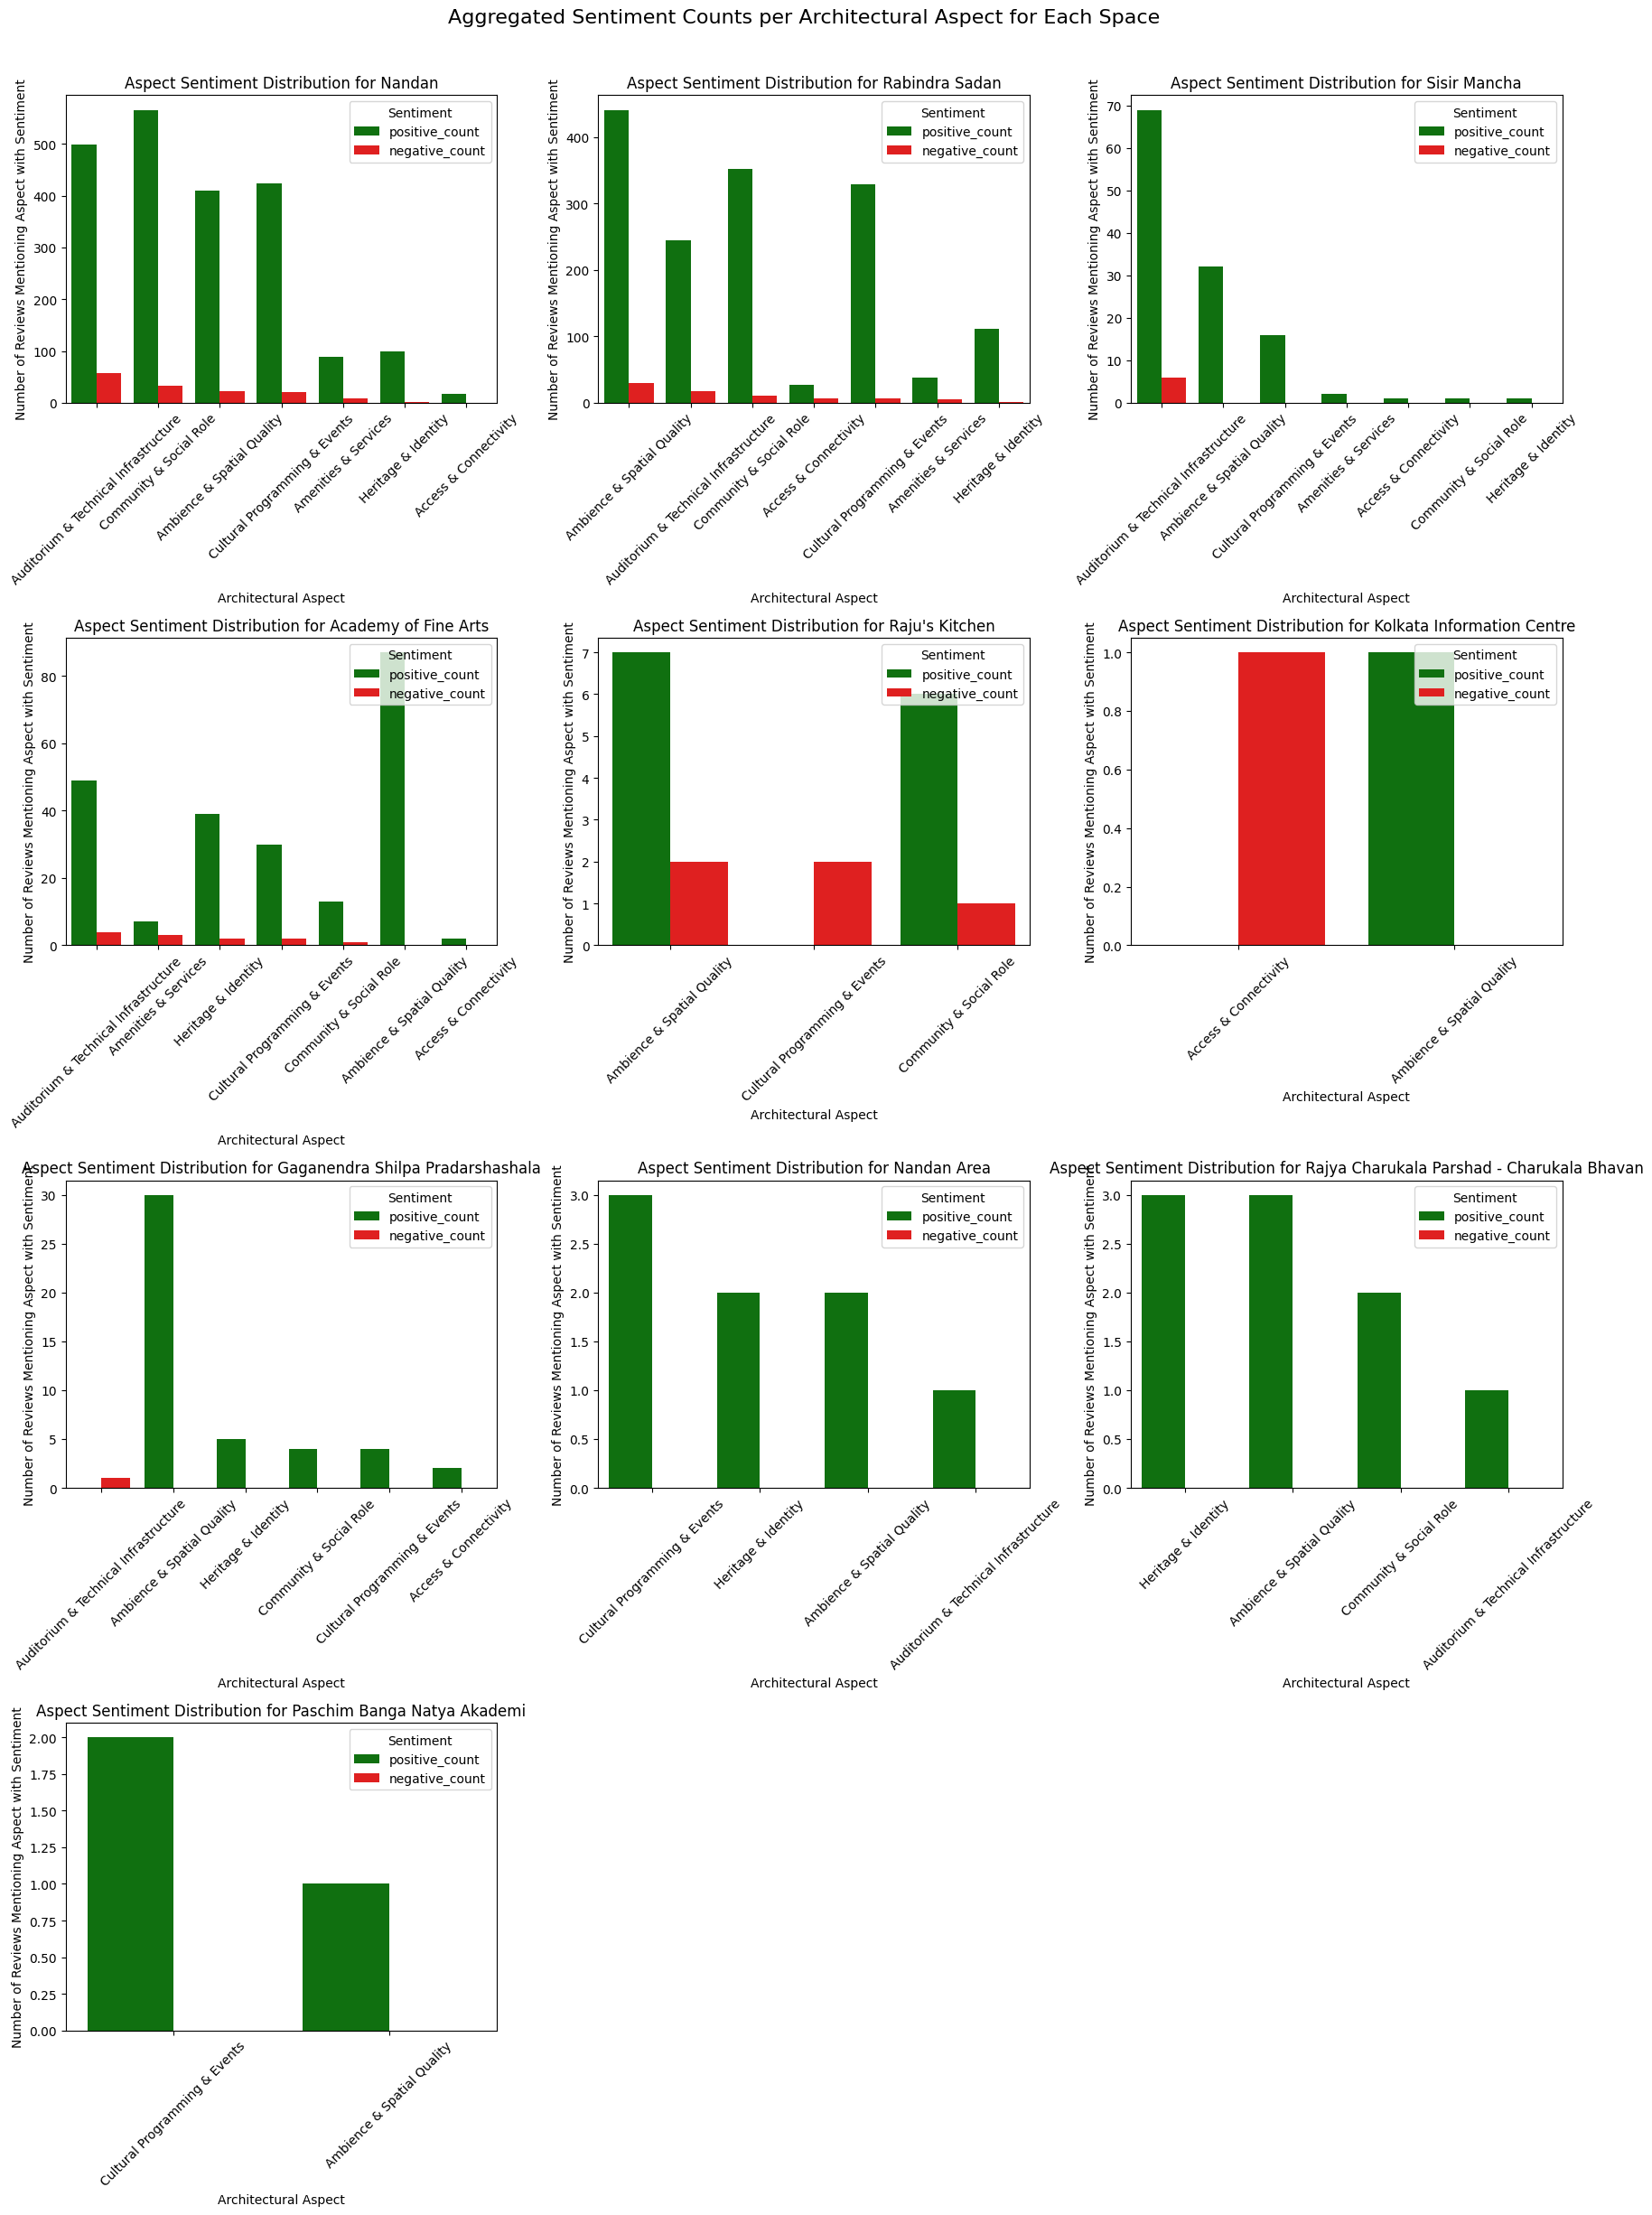

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # Import numpy for plotting

# Use the aspect_sentiment_df
spaces = aspect_sentiment_df["location"].unique()
n_spaces = len(spaces)
n_cols = 3
n_rows = (n_spaces + n_cols - 1) // n_cols # More robust way to calculate rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows)) # Increased figsize
axes = axes.flatten() if n_spaces > 1 else [axes] # Handle case with only one space

# Define colors
colors = {'positive_count': 'green', 'negative_count': 'red'}

for i, space in enumerate(spaces):
    # Filter data for the current space
    subset_df = aspect_sentiment_df[aspect_sentiment_df["location"] == space].copy()

    # Melt the DataFrame to have sentiment types as a column for plotting
    melted_df = subset_df.melt(
        id_vars='aspect',
        value_vars=['positive_count', 'negative_count'],
        var_name='sentiment_type',
        value_name='count'
    )

    # Create a bar plot
    sns.barplot(
        data=melted_df,
        x='aspect',
        y='count',
        hue='sentiment_type',
        palette=colors,
        ax=axes[i]
    )

    axes[i].set_title(f"Aspect Sentiment Distribution for {space}", fontsize=12)
    axes[i].set_xlabel("Architectural Aspect", fontsize=10)
    axes[i].set_ylabel("Number of Reviews Mentioning Aspect with Sentiment", fontsize=10)
    axes[i].tick_params(axis='x', rotation=45) # Removed ha='right'
    axes[i].legend(title="Sentiment", loc='upper right')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Aggregated Sentiment Counts per Architectural Aspect for Each Space", y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1.01])
plt.show()

### Refined Architectural Aspects

Based on the manual review of key terms and bigrams, the following 7 architectural aspects have been defined for further analysis:

*   **Ambience & Spatial Quality:** Focus on spatial experience, circulation, open spaces, comfort.
*   **Cultural Programming & Events:** Focus on multipurpose halls, flexible cultural venues, exhibition spaces.
*   **Access & Connectivity:** Focus on seamless pedestrian links, parking solutions, transit integration.
*   **Auditorium & Technical Infrastructure:** Focus on reconfiguring auditoria, modern acoustics, AV systems, modular seating.
*   **Amenities & Services:** Focus on redesigned cafés, food court, sanitation, universal accessibility.
*   **Heritage & Identity:** Focus on adaptive reuse, façade conservation, integration of modern language with tradition.
*   **Community & Social Role:** Focus on inclusive plazas, informal gathering pockets, public edge activation.

In [39]:
import pandas as pd

# Define the UPDATED architectural aspects and their associated terms/phrases (from user input)
# Use terms in lowercase for easier matching
architectural_aspects_refined = {
    "Ambience & Spatial Quality": ["nice place", "beautiful", "crowded", "bad seating", "congested"],
    "Cultural Programming & Events": ["film festival", "cultural hub", "programs", "events", "performances"],
    "Access & Connectivity": ["near metro", "easy to reach", "parking problem", "traffic", "public transport"],
    "Auditorium & Technical Infrastructure": ["auditorium", "sound quality", "bad acoustics", "screen", "lighting issues"],
    "Amenities & Services": ["food stalls", "cafeteria", "clean toilets", "hygiene problem", "facilities"],
    "Heritage & Identity": ["cultural heritage", "Bengali culture", "art lovers", "emotional value"],
    "Community & Social Role": ["hangout", "family spot", "friends", "favourite", "public gathering"]
}

# Flatten the list of terms and map each term back to its aspect(s)
term_to_aspect_refined = {}
for aspect, terms in architectural_aspects_refined.items():
    for term in terms:
        # Ensure the term is a string before lowercasing
        if isinstance(term, str):
            term_to_aspect_refined.setdefault(term.lower(), []).append(aspect)


# Function to identify which aspects are mentioned in a review using the refined aspects
def get_mentioned_aspects_refined(review_text, term_to_aspect_map):
    if not isinstance(review_text, str):
        return []
    mentioned = set()
    review_text_lower = review_text.lower()
    for term in term_to_aspect_map.keys():
        if term in review_text_lower:
            for aspect in term_to_aspect_map[term]:
                 mentioned.add(aspect)
    return list(mentioned)

# Apply the updated function to identify mentioned aspects for each review
# This will overwrite the previous 'mentioned_aspects' column based on the new aspects
final_sentiment_df['mentioned_aspects'] = final_sentiment_df['review'].apply(
    lambda x: get_mentioned_aspects_refined(x, term_to_aspect_refined)
)

# Now, aggregate sentiment per aspect per location using the refined aspects
# Create a list to store results
aspect_sentiment_list_refined = []

# Iterate through each location and each aspect
for location in final_sentiment_df['location'].unique():
    for aspect in architectural_aspects_refined.keys():
        # Filter reviews for the current location
        location_subset = final_sentiment_df[final_sentiment_df['location'] == location]

        # Filter reviews that mention the current aspect based on the refined aspects
        aspect_reviews = location_subset[
            location_subset['mentioned_aspects'].apply(lambda aspects: aspect in aspects)
        ]

        if not aspect_reviews.empty:
            # Calculate aggregated sentiment for this aspect in this location
            avg_sentiment_score = aspect_reviews['sentiment score'].mean()
            # Count positive, negative reviews for this aspect in this location (using adjusted sentiment)
            sentiment_counts = aspect_reviews['sentiment (bert)'].value_counts().to_dict()
            total_reviews_mentioning_aspect = aspect_reviews.shape[0]


            aspect_sentiment_list_refined.append({
                'location': location,
                'aspect': aspect,
                'avg_sentiment_score': avg_sentiment_score,
                'total_reviews_mentioning': total_reviews_mentioning_aspect,
                'positive_count': sentiment_counts.get('POSITIVE', 0),
                'negative_count': sentiment_counts.get('NEGATIVE', 0)
                # Excluded neutral count as requested previously
            })

# Create a DataFrame from the results
aspect_sentiment_df_refined = pd.DataFrame(aspect_sentiment_list_refined)

# Sort the DataFrame to emphasize negative counts
aspect_sentiment_df_refined = aspect_sentiment_df_refined.sort_values(
    by=['negative_count', 'total_reviews_mentioning', 'avg_sentiment_score'],
    ascending=[False, False, True] # Sort by negative count (desc), total reviews (desc), avg score (asc)
)


# Display the results
print("Aggregated Sentiment per Refined Aspect per Location (Sorted by Negative Count):")
display(aspect_sentiment_df_refined)

# Rename the refined DataFrame to the standard name for consistency with future steps
aspect_sentiment_df = aspect_sentiment_df_refined

Aggregated Sentiment per Refined Aspect per Location (Sorted by Negative Count):


location  \
3                                       Nandan   
6                                       Nandan   
42                              Rabindra Sadan   
0                                       Nandan   
1                                       Nandan   
45                              Rabindra Sadan   
48                              Rabindra Sadan   
4                                       Nandan   
44                              Rabindra Sadan   
43                              Rabindra Sadan   
22                                Sisir Mancha   
46                              Rabindra Sadan   
29                        Academy of Fine Arts   
30                        Academy of Fine Arts   
31                        Academy of Fine Arts   
27                        Academy of Fine Arts   
33                              Raju's Kitchen   
34                              Raju's Kitchen   
47                              Rabindra Sadan   
5                                       Nandan   
32                        Academy of Fine Arts   
35                              Raju's Kitchen   
18                  Kolkata Information Centre   
39            Gaganendra Shilpa Pradarshashala   
26                        Academy of Fine Arts   
19                                Sisir Mancha   
36            Gaganendra Shilpa Pradarshashala   
2                                       Nandan   
20                                Sisir Mancha   
40            Gaganendra Shilpa Pradarshashala   
41            Gaganendra Shilpa Pradarshashala   
37            Gaganendra Shilpa Pradarshashala   
14                                 Nandan Area   
11  Rajya Charukala Parshad - Charukala Bhavan   
9   Rajya Charukala Parshad - Charukala Bhavan   
8                  Paschim Banga Natya Akademi   
16                                 Nandan Area   
38            Gaganendra Shilpa Pradarshashala   
12  Rajya Charukala Parshad - Charukala Bhavan   
28                        Academy of Fine Arts   
23                                Sisir Mancha   
13                                 Nandan Area   
21                                Sisir Mancha   
10  Rajya Charukala Parshad - Charukala Bhavan   
15                                 Nandan Area   
25                                Sisir Mancha   
24                                Sisir Mancha   
7                  Paschim Banga Natya Akademi   
17                  Kolkata Information Centre   

                                   aspect  avg_sentiment_score  \
3   Auditorium & Technical Infrastructure             0.984082   
6                 Community & Social Role             0.989160   
42             Ambience & Spatial Quality             0.994803   
0              Ambience & Spatial Quality             0.990300   
1           Cultural Programming & Events             0.991384   
45  Auditorium & Technical Infrastructure             0.994022   
48                Community & Social Role             0.997023   
4                    Amenities & Services             0.977425   
44                  Access & Connectivity             0.975032   
43          Cultural Programming & Events             0.997123   
22  Auditorium & Technical Infrastructure             0.981293   
46                   Amenities & Services             0.993142   
29  Auditorium & Technical Infrastructure             0.987565   
30                   Amenities & Services             0.994595   
31                    Heritage & Identity             0.997175   
27          Cultural Programming & Events             0.993655   
33             Ambience & Spatial Quality             0.998979   
34          Cultural Programming & Events             0.996227   
47                    Heritage & Identity             0.998710   
5                     Heritage & Identity             0.993447   
32                Community & Social Role             0.962679   
35                Community & Social Role             0.992387   
18                 

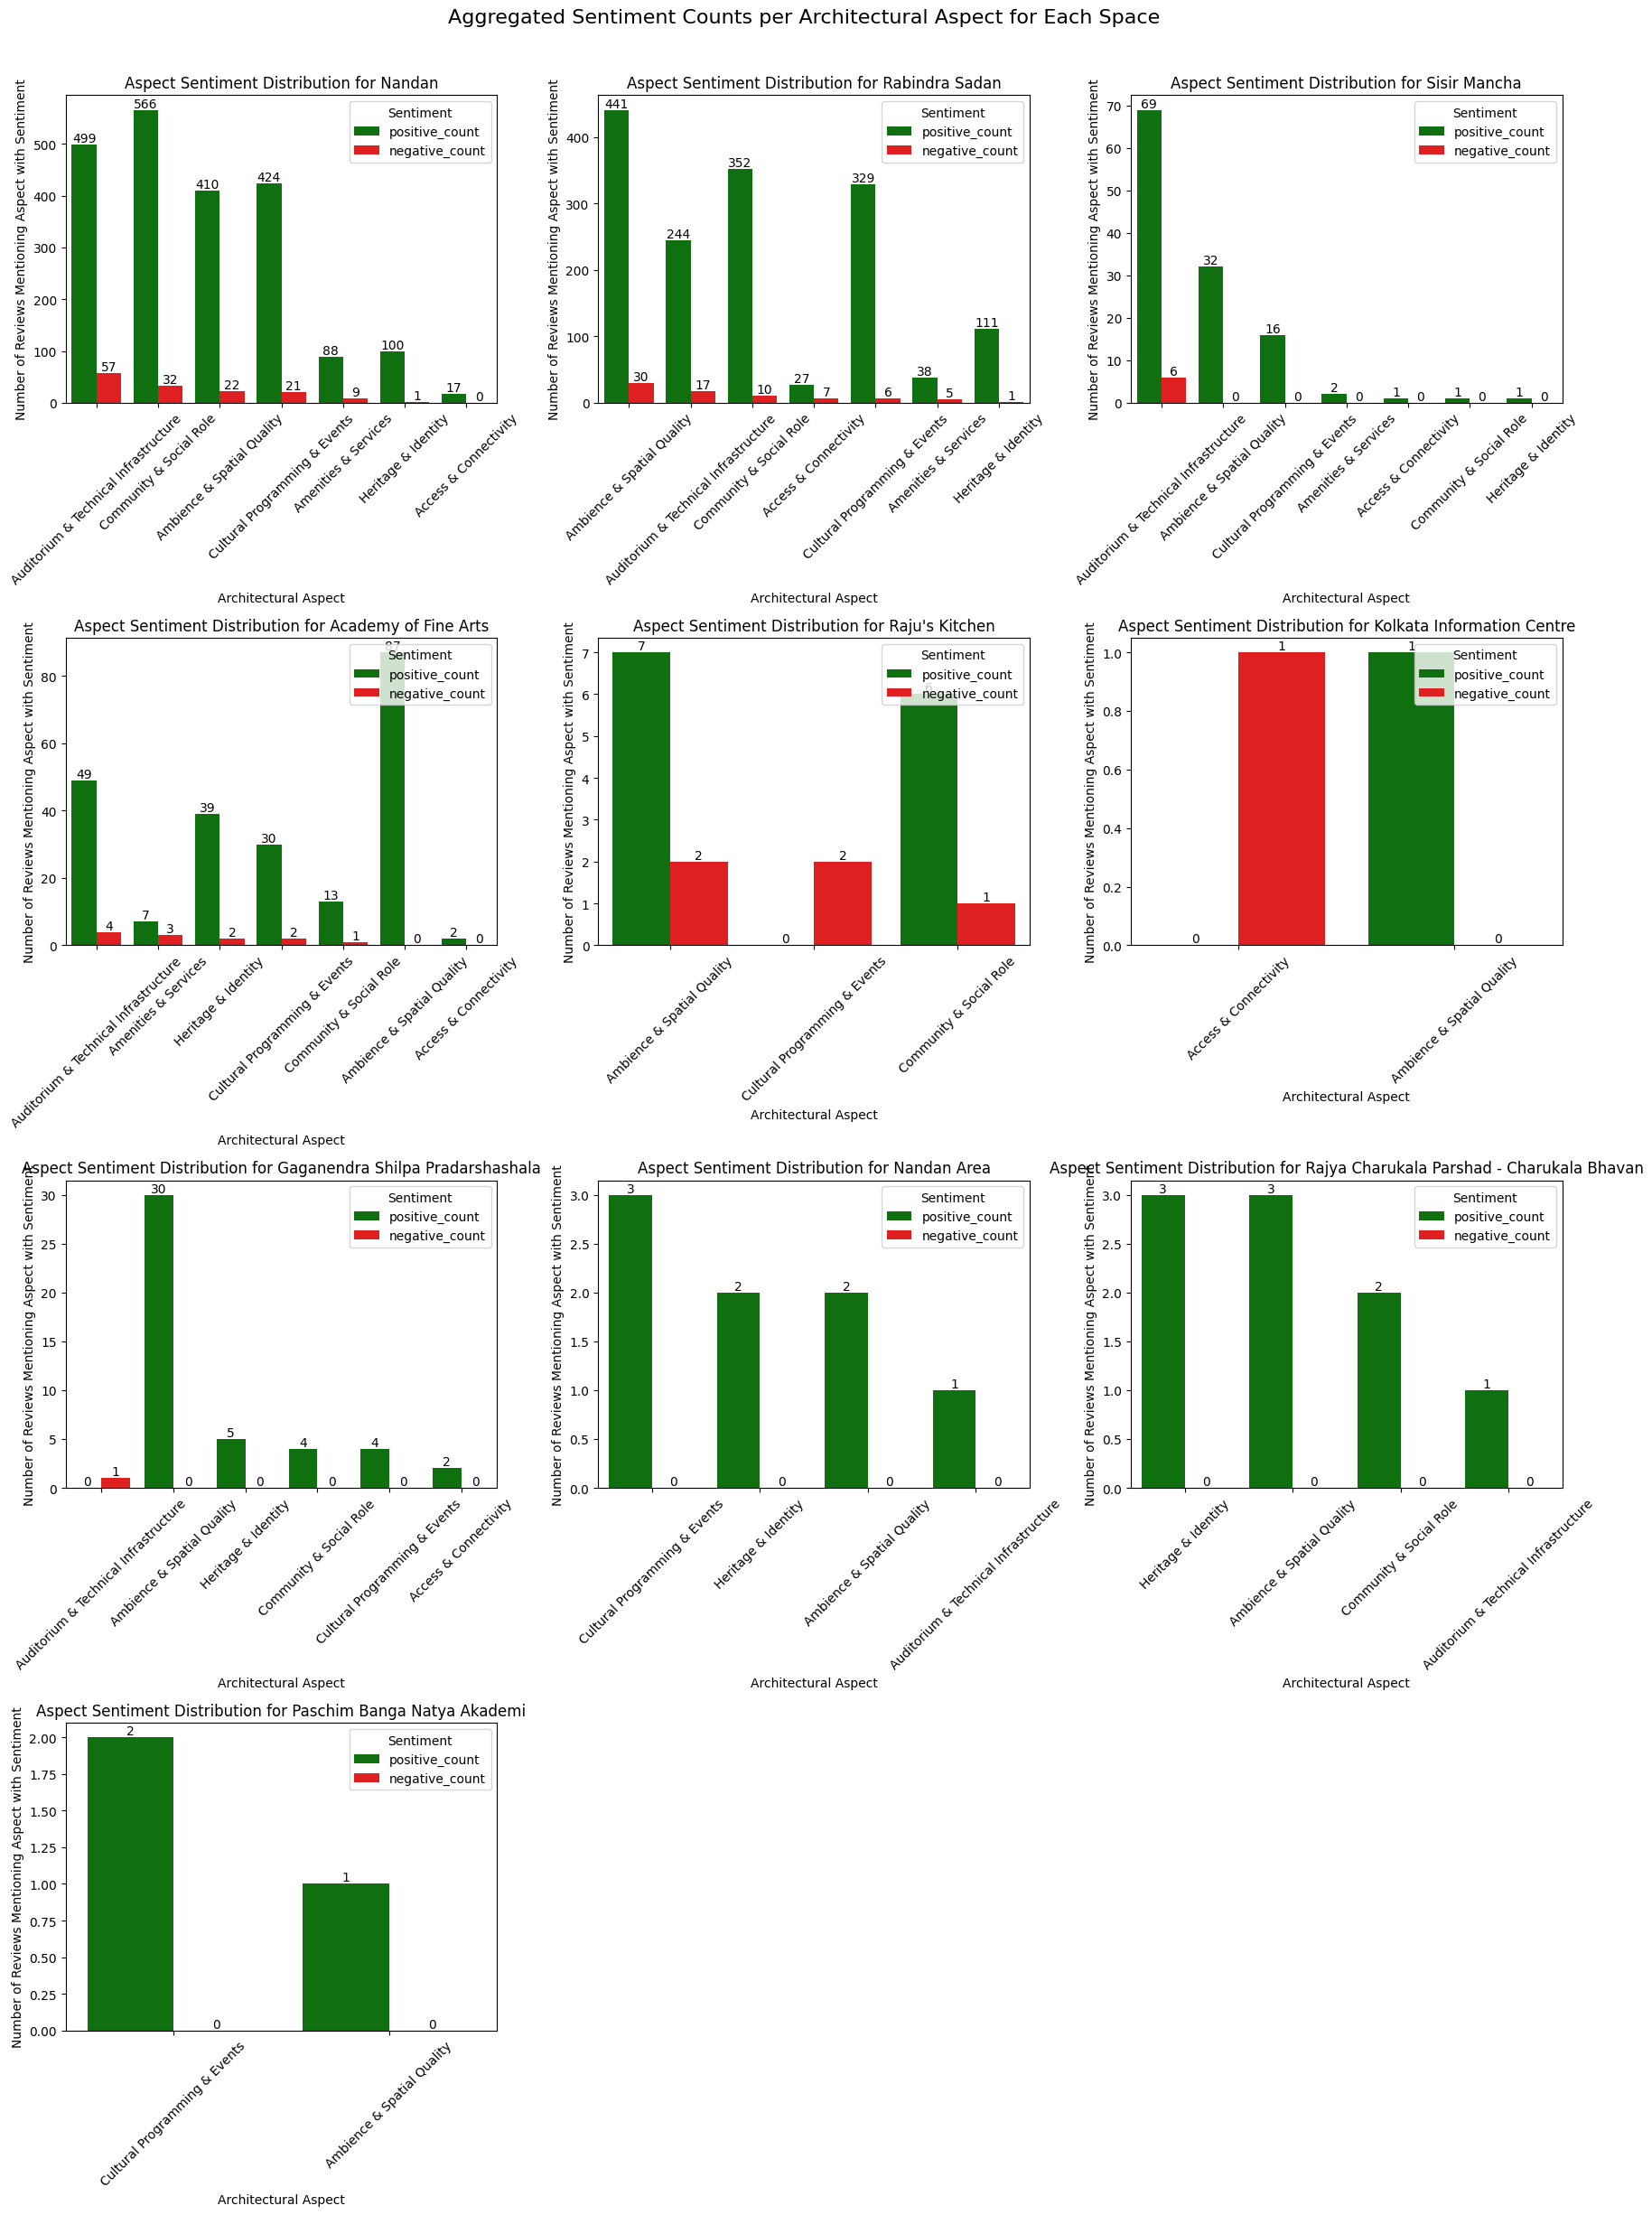

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # Import numpy for plotting

# Use the aspect_sentiment_df
spaces = aspect_sentiment_df["location"].unique()
n_spaces = len(spaces)
n_cols = 3
n_rows = (n_spaces + n_cols - 1) // n_cols # More robust way to calculate rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows)) # Increased figsize
axes = axes.flatten() if n_spaces > 1 else [axes] # Handle case with only one space

# Define colors
colors = {'positive_count': 'green', 'negative_count': 'red'}

for i, space in enumerate(spaces):
    # Filter data for the current space
    subset_df = aspect_sentiment_df[aspect_sentiment_df["location"] == space].copy()

    # Melt the DataFrame to have sentiment types as a column for plotting
    melted_df = subset_df.melt(
        id_vars='aspect',
        value_vars=['positive_count', 'negative_count'],
        var_name='sentiment_type',
        value_name='count'
    )

    # Create a bar plot
    sns.barplot(
        data=melted_df,
        x='aspect',
        y='count',
        hue='sentiment_type',
        palette=colors,
        ax=axes[i]
    )

    axes[i].set_title(f"Aspect Sentiment Distribution for {space}", fontsize=12)
    axes[i].set_xlabel("Architectural Aspect", fontsize=10)
    axes[i].set_ylabel("Number of Reviews Mentioning Aspect with Sentiment", fontsize=10)
    axes[i].tick_params(axis='x', rotation=45) # Removed ha='right'
    axes[i].legend(title="Sentiment", loc='upper right')
    # Add counts on top of bars
    for container in axes[i].containers:
        axes[i].bar_label(container)


# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Aggregated Sentiment Counts per Architectural Aspect for Each Space", y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1.01])
plt.show()

ValueError: Unknown format code 'd' for object of type 'float'

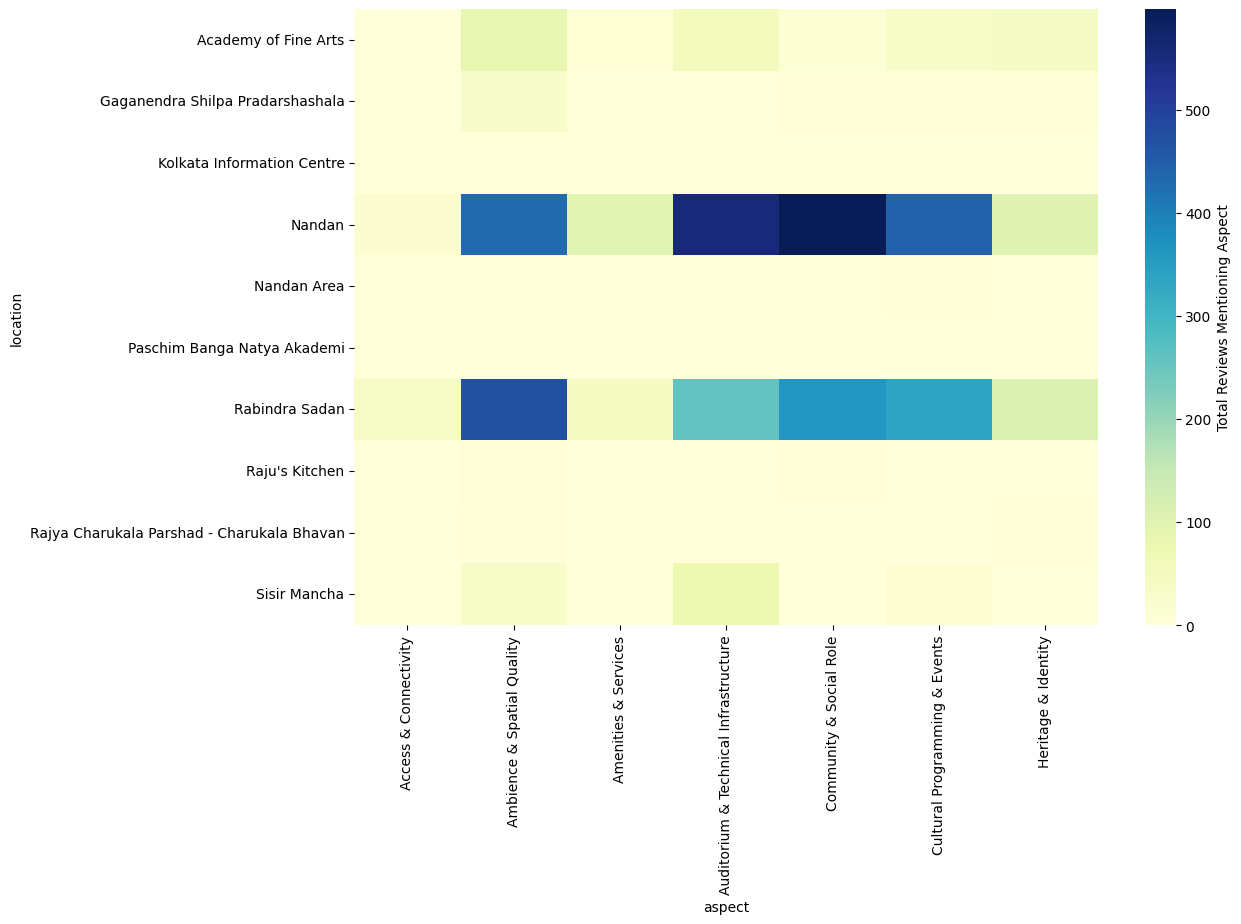

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Use the aspect_sentiment_df
# Pivot the DataFrame to create a matrix suitable for a heatmap
# Rows will be locations, columns will be aspects, and values will be total reviews mentioning the aspect
heatmap_data_total = aspect_sentiment_df.pivot_table(
    index='location',
    columns='aspect',
    values='total_reviews_mentioning',
    fill_value=0 # Fill missing values with 0
)

# Create the heatmap
plt.figure(figsize=(12, 8)) # Adjust figure size as needed
sns.heatmap(heatmap_data_total, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Total Reviews Mentioning Aspect'})
plt.title('Heatmap of Total Reviews Mentioning Each Architectural Aspect per Location')
plt.xlabel('Architectural Aspect')
plt.ylabel('Location')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

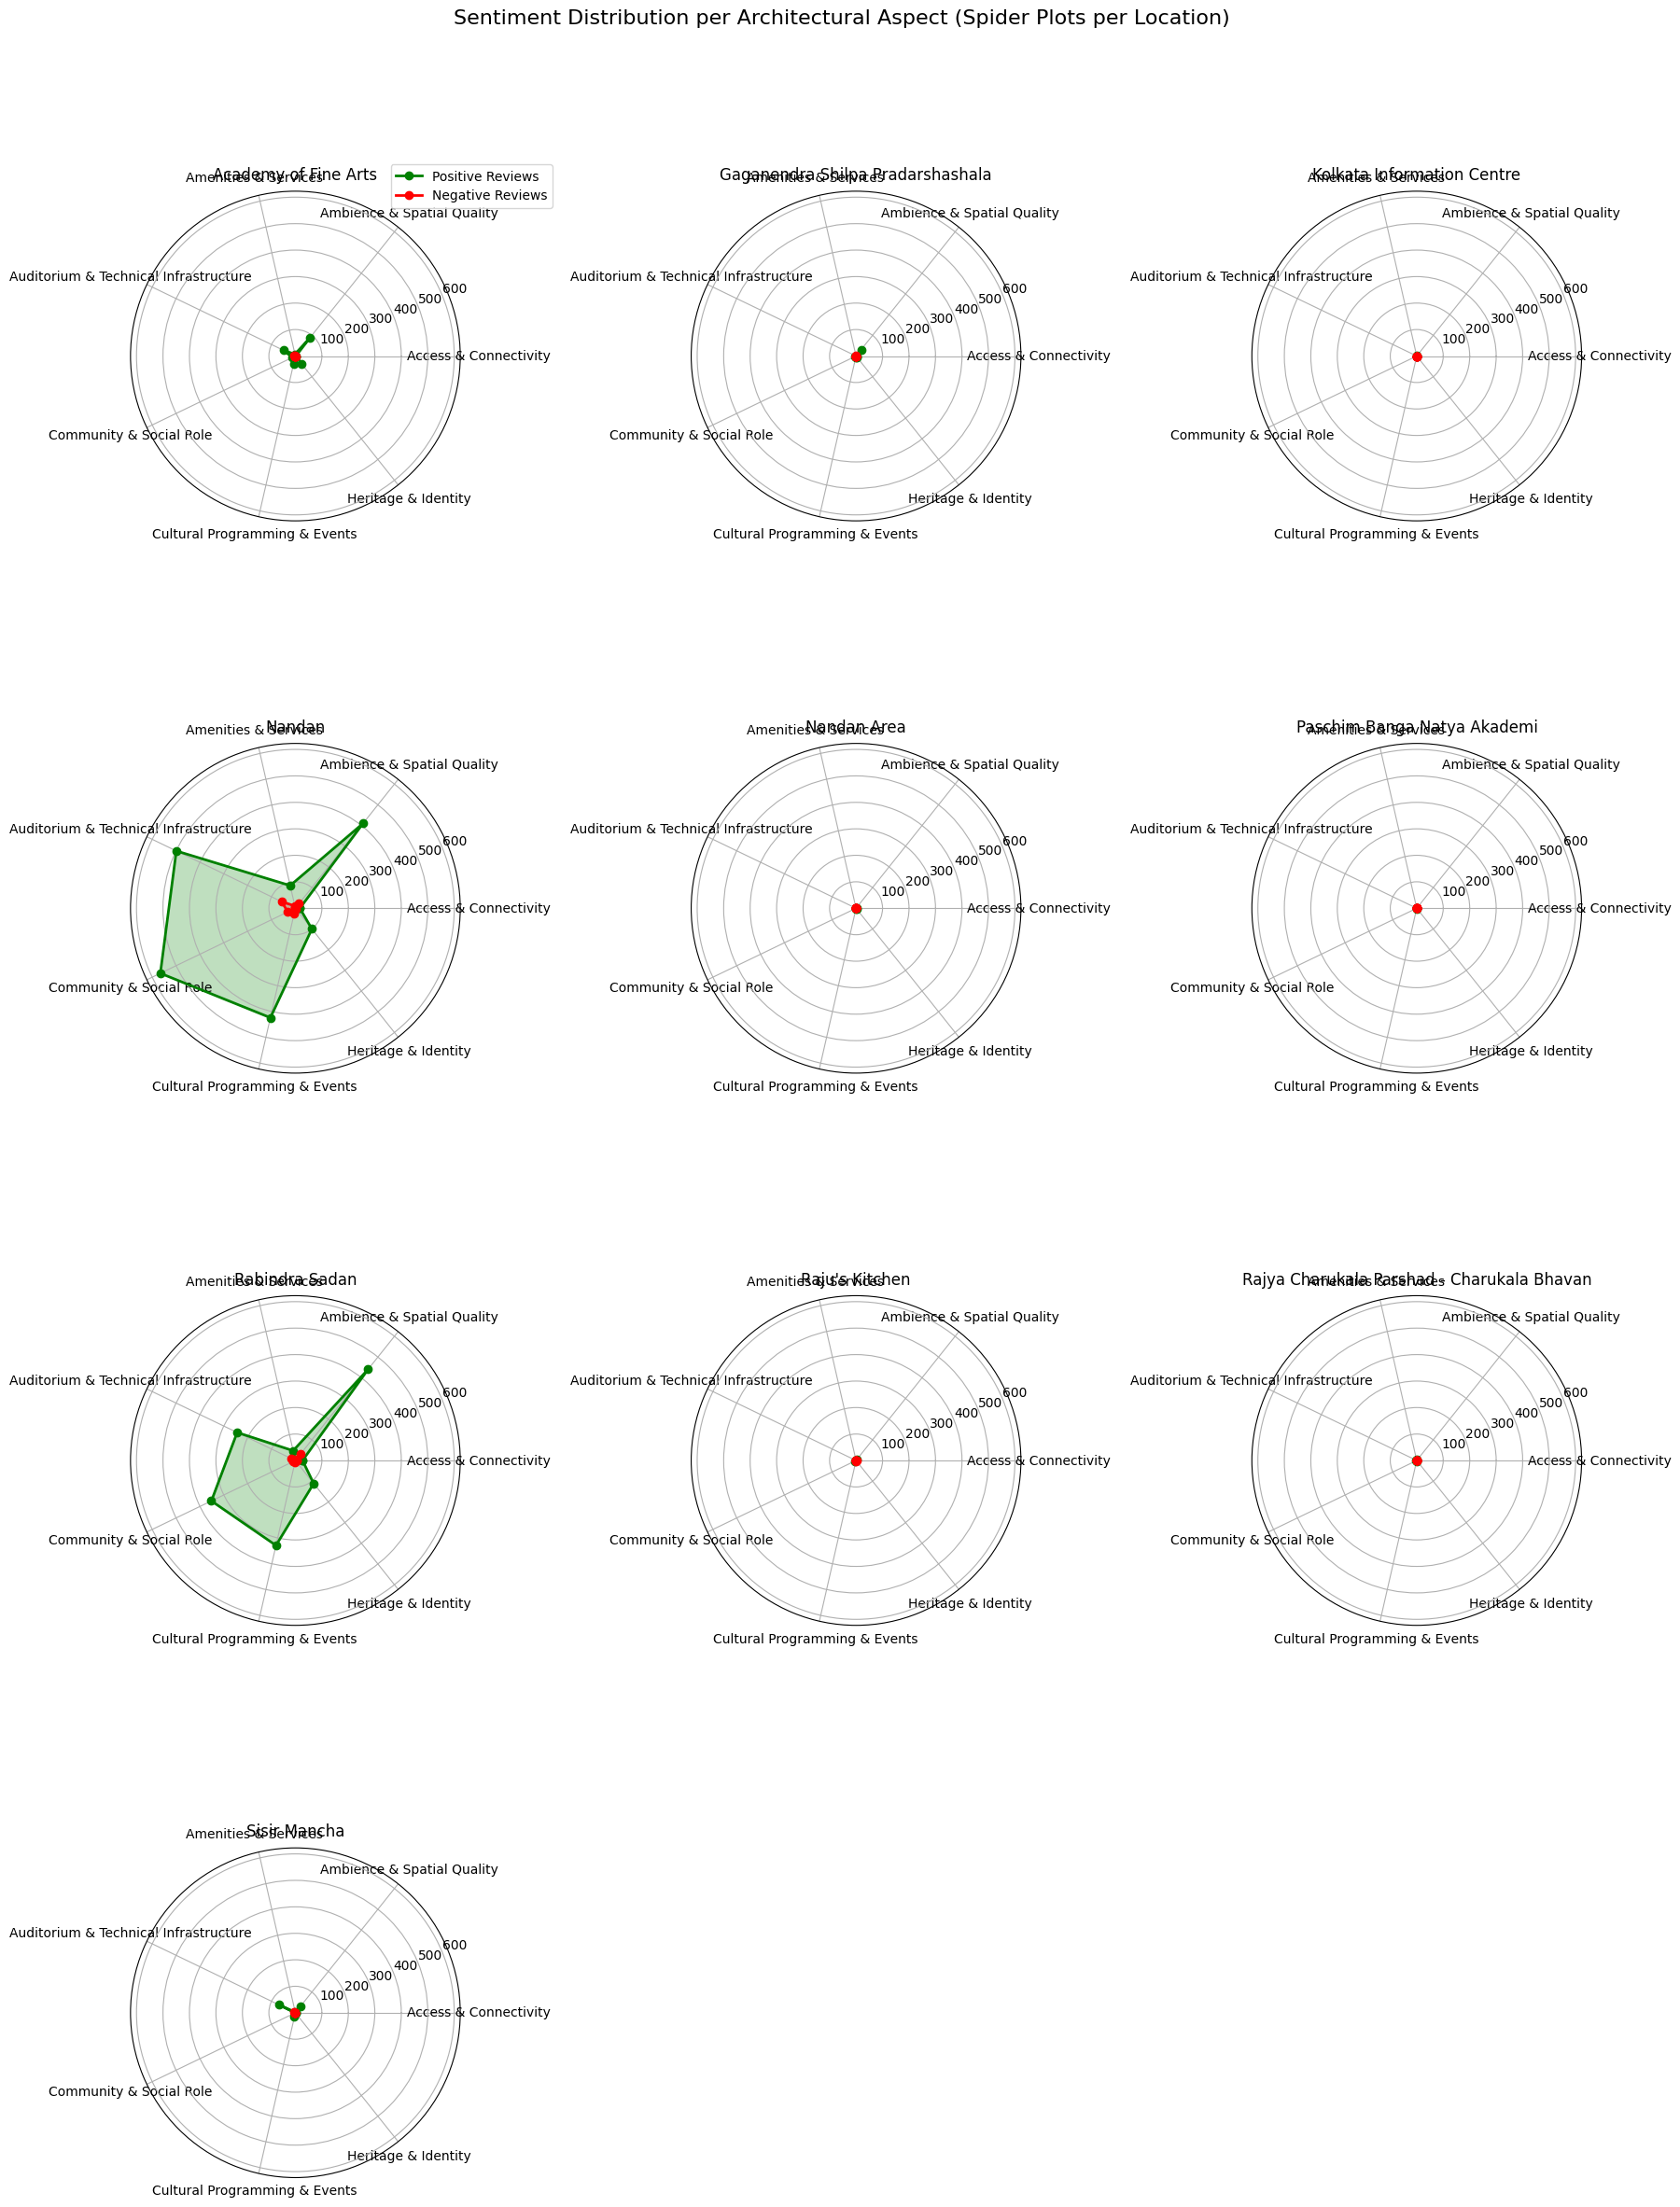

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Use the aspect_sentiment_df
# Prepare data for spider plots
# We need a DataFrame where rows are locations, columns are aspects,
# and values are the positive and negative counts.

# Pivot for positive counts
heatmap_data_positive = aspect_sentiment_df.pivot_table(
    index='location',
    columns='aspect',
    values='positive_count',
    fill_value=0
)

# Pivot for negative counts
heatmap_data_negative = aspect_sentiment_df.pivot_table(
    index='location',
    columns='aspect',
    values='negative_count',
    fill_value=0
)

# Get the list of aspects (columns) - they should be the same for both
aspects = heatmap_data_positive.columns.tolist()

# Number of aspects
num_aspects = len(aspects)

# Set the angle for each aspect
angles = np.linspace(0, 2*np.pi, num_aspects, endpoint=False).tolist()
angles += angles[:1] # Complete the circle

# Create a figure and axes for each location
locations = heatmap_data_positive.index.tolist()
n_locations = len(locations)
n_cols = 3 # You can adjust the number of columns
n_rows = (n_locations + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows), subplot_kw=dict(polar=True))
axes = axes.flatten() if n_locations > 1 else [axes] # Handle single location case

# Plotting each location
for i, location in enumerate(locations):
    ax = axes[i]

    # Get positive and negative counts for the current location
    positive_values = heatmap_data_positive.loc[location].tolist()
    negative_values = heatmap_data_negative.loc[location].tolist()

    # Complete the circle for values
    positive_values += positive_values[:1]
    negative_values += negative_values[:1]

    # Plot positive counts
    ax.plot(angles, positive_values, 'o-', linewidth=2, color='green', label='Positive Reviews')
    ax.fill(angles, positive_values, color='green', alpha=0.25)

    # Plot negative counts
    ax.plot(angles, negative_values, 'o-', linewidth=2, color='red', label='Negative Reviews')
    ax.fill(angles, negative_values, color='red', alpha=0.25)

    # Set the labels and title
    ax.set_thetagrids(np.degrees(angles[:-1]), aspects)
    ax.set_title(location, va='bottom', fontsize=12)
    ax.grid(True)

    # Add a legend to the first plot
    if i == 0:
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    # Set the y-axis limits to be consistent across plots for better comparison
    # Find the maximum count across all positive and negative values for all locations
    max_count = max(heatmap_data_positive.values.max(), heatmap_data_negative.values.max())
    ax.set_ylim(0, max_count + max_count * 0.1) # Add a little buffer

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.suptitle("Sentiment Distribution per Architectural Aspect (Spider Plots per Location)", y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1.01])
plt.show()

DataFrame with Normalized Sentiment Counts (per Aspect per Location - Normalized by Total Location Reviews):


location                                 aspect  avg_sentiment_score  \
0          Nandan  Auditorium & Technical Infrastructure             0.984082   
1          Nandan                Community & Social Role             0.989160   
2  Rabindra Sadan             Ambience & Spatial Quality             0.994803   
3          Nandan             Ambience & Spatial Quality             0.990300   
4          Nandan          Cultural Programming & Events             0.991384   

   total_reviews_mentioning  positive_count  negative_count  \
0                       556             499              57   
1                       598             566              32   
2                       471             441              30   
3                       432             410              22   
4                       445             424              21   

   total_location_reviews  normalized_positive  normalized_negative  
0                    2998             0.166444             0.019013  
1                    2998             0.188793             0.010674  
2                    2987             0.147640             0.010044  
3                    2998             0.136758             0.007338  
4                    2998             0.141428             0.007005

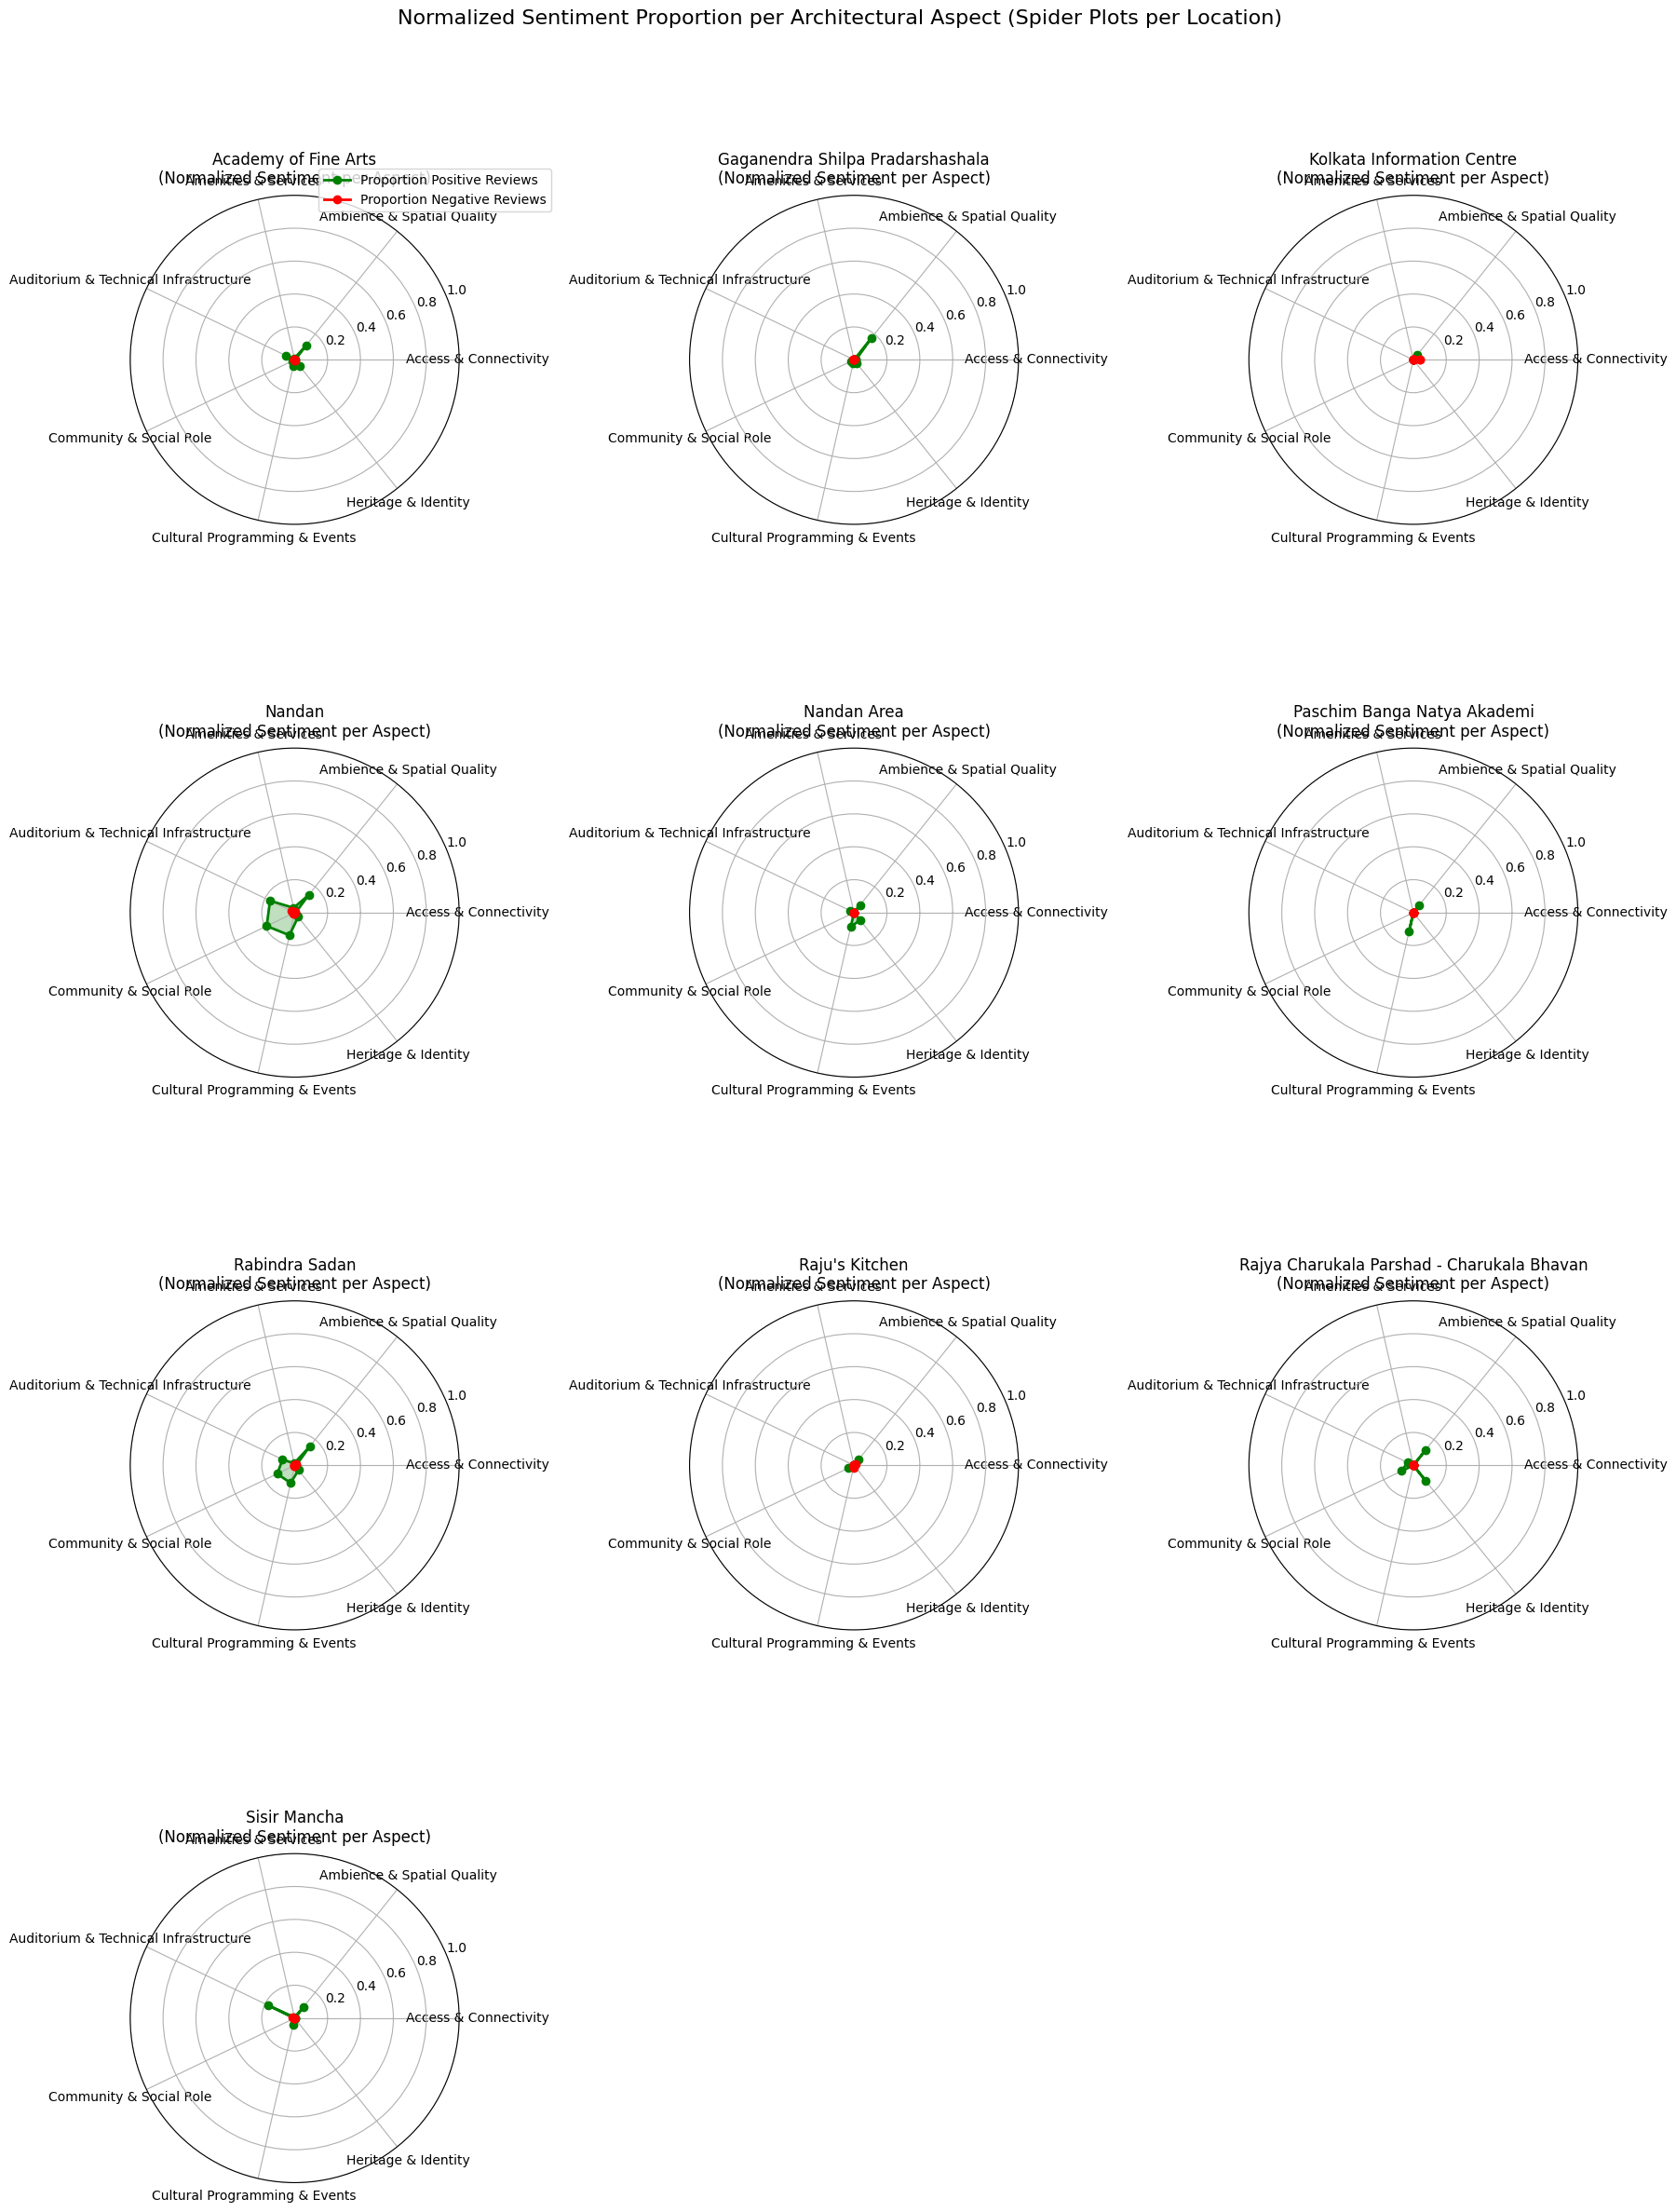

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Although not directly used in the spider plot code, it's good practice to keep necessary imports together

# Use the existing aspect_sentiment_df
# Calculate the total number of reviews for each location
total_reviews_per_location = final_sentiment_df['location'].value_counts().reset_index()
total_reviews_per_location.columns = ['location', 'total_location_reviews']

# Merge this total count back into the aspect_sentiment_df
aspect_sentiment_df = pd.merge(aspect_sentiment_df, total_reviews_per_location, on='location', how='left')


# Calculate normalized positive and negative counts per aspect per location
# Normalize by the total number of reviews FOR THE ENTIRE LOCATION
aspect_sentiment_df['normalized_positive'] = aspect_sentiment_df.apply(
    lambda row: row['positive_count'] / row['total_location_reviews'] if row['total_location_reviews'] > 0 else 0,
    axis=1
)

aspect_sentiment_df['normalized_negative'] = aspect_sentiment_df.apply(
    lambda row: row['negative_count'] / row['total_location_reviews'] if row['total_location_reviews'] > 0 else 0,
    axis=1
)

# Display the DataFrame with normalized values
print("DataFrame with Normalized Sentiment Counts (per Aspect per Location - Normalized by Total Location Reviews):")
display(aspect_sentiment_df.head())

# Prepare data for spider plots using normalized counts
# Pivot for normalized positive counts
heatmap_data_positive_normalized = aspect_sentiment_df.pivot_table(
    index='location',
    columns='aspect',
    values='normalized_positive',
    fill_value=0
)

# Pivot for normalized negative counts
heatmap_data_negative_normalized = aspect_sentiment_df.pivot_table(
    index='location',
    columns='aspect',
    values='normalized_negative',
    fill_value=0
)

# Get the list of aspects (columns)
aspects_normalized = heatmap_data_positive_normalized.columns.tolist()

# Number of aspects
num_aspects_normalized = len(aspects_normalized)

# Set the angle for each aspect
angles_normalized = np.linspace(0, 2*np.pi, num_aspects_normalized, endpoint=False).tolist()
angles_normalized += angles_normalized[:1] # Complete the circle

# Create a figure and axes for each location
locations_normalized = heatmap_data_positive_normalized.index.tolist()
n_locations_normalized = len(locations_normalized)
n_cols_normalized = 3 # Same number of columns as before
n_rows_normalized = (n_locations_normalized + n_cols_normalized - 1) // n_cols_normalized

fig_normalized, axes_normalized = plt.subplots(n_rows_normalized, n_cols_normalized, figsize=(18, 6 * n_rows_normalized), subplot_kw=dict(polar=True))
axes_normalized = axes_normalized.flatten() if n_locations_normalized > 1 else [axes_normalized] # Handle single location case

# Plotting each location using normalized values
for i, location in enumerate(locations_normalized):
    ax = axes_normalized[i]

    # Get normalized positive and negative values for the current location
    positive_values_normalized = heatmap_data_positive_normalized.loc[location].tolist()
    negative_values_normalized = heatmap_data_negative_normalized.loc[location].tolist()

    # Complete the circle for values
    positive_values_normalized += positive_values_normalized[:1]
    negative_values_normalized += negative_values_normalized[:1]

    # Plot normalized positive counts
    ax.plot(angles_normalized, positive_values_normalized, 'o-', linewidth=2, color='green', label='Proportion Positive Reviews')
    ax.fill(angles_normalized, positive_values_normalized, color='green', alpha=0.25)

    # Plot normalized negative counts
    ax.plot(angles_normalized, negative_values_normalized, 'o-', linewidth=2, color='red', label='Proportion Negative Reviews')
    ax.fill(angles_normalized, negative_values_normalized, color='red', alpha=0.25)

    # Set the labels and title
    ax.set_thetagrids(np.degrees(angles_normalized[:-1]), aspects_normalized)
    ax.set_title(f"{location}\n(Normalized Sentiment per Aspect)", va='bottom', fontsize=12)
    ax.grid(True)

    # Add a legend to the first plot
    if i == 0:
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    # Set the y-axis limits from 0 to 1 as they are proportions
    ax.set_ylim(0, 1)


# Remove unused subplots
for j in range(i + 1, len(axes_normalized)):
    fig_normalized.delaxes(axes_normalized[j])


plt.suptitle("Normalized Sentiment Proportion per Architectural Aspect (Spider Plots per Location)", y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1.01])
plt.show()

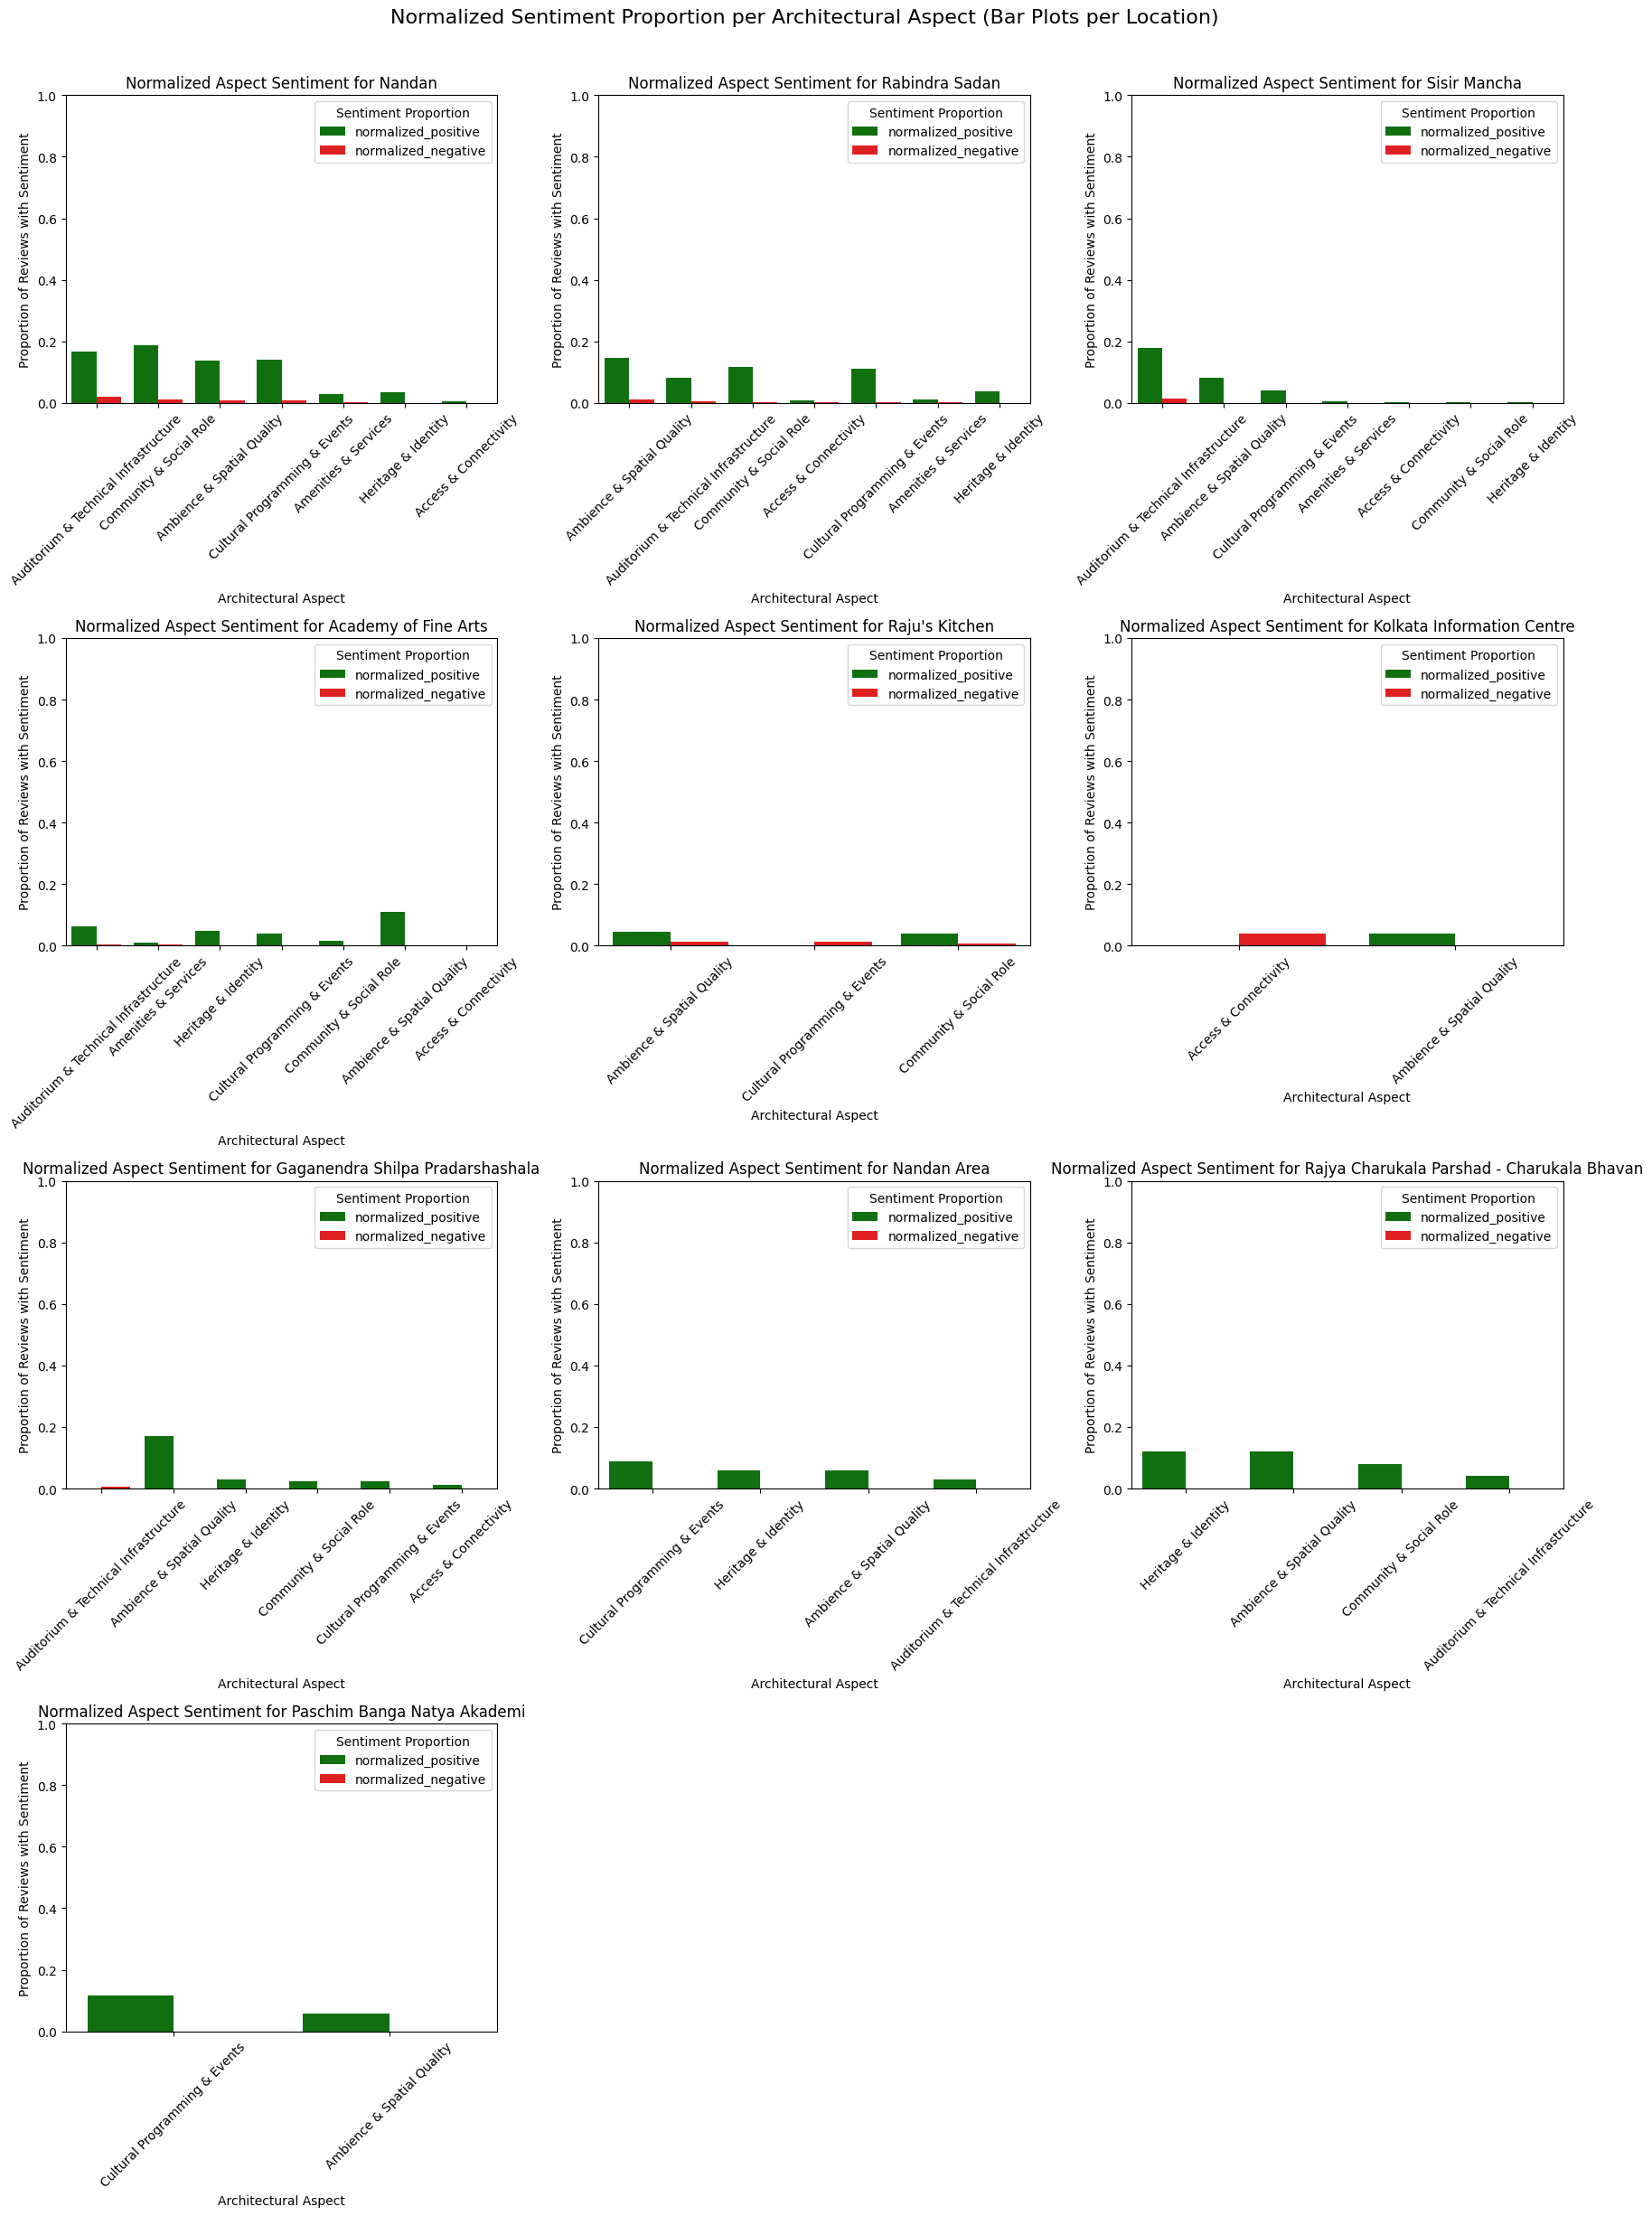

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Use the aspect_sentiment_df with normalized values
spaces = aspect_sentiment_df["location"].unique()
n_spaces = len(spaces)
n_cols = 3
n_rows = (n_spaces + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
axes = axes.flatten() if n_spaces > 1 else [axes]

# Define colors
colors = {'normalized_positive': 'green', 'normalized_negative': 'red'}

for i, space in enumerate(spaces):
    ax = axes[i]

    # Filter data for the current space
    subset_df = aspect_sentiment_df[aspect_sentiment_df["location"] == space].copy()

    # Melt the DataFrame to have normalized sentiment proportions as a column
    melted_df = subset_df.melt(
        id_vars='aspect',
        value_vars=['normalized_positive', 'normalized_negative'],
        var_name='sentiment_type',
        value_name='proportion' # Renamed to proportion
    )

    # Create a bar plot using normalized proportions
    sns.barplot(
        data=melted_df,
        x='aspect',
        y='proportion', # Use proportion for y-axis
        hue='sentiment_type',
        palette=colors,
        ax=ax
    )

    ax.set_title(f"Normalized Aspect Sentiment for {space}", fontsize=12)
    ax.set_xlabel("Architectural Aspect", fontsize=10)
    ax.set_ylabel("Proportion of Reviews with Sentiment", fontsize=10) # Updated label
    ax.tick_params(axis='x', rotation=45) # Rotate labels, removed ha='right'
    ax.set_ylim(0, 1) # Set y-axis limit from 0 to 1 for proportions
    ax.legend(title="Sentiment Proportion", loc='upper right')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Normalized Sentiment Proportion per Architectural Aspect (Bar Plots per Location)", y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1.01])
plt.show()

# Conclusion

## Conclusion

Stepping back and looking at the Rabindra Sadan Complex as a whole through the lens of public reviews, here's an architectural interpretation of the feedback for each space, incorporating the numbers from our analysis:

*   **Nandan (2998 reviews, Avg Stars: 4.72):** A vibrant cultural and social anchor. High positive sentiment (2689 positive BERT) highlights successful spatial design for gathering and events ("Community & Social Role" - 566 positive, 32 negative mentions). However, the significant negative feedback on "Auditorium & Technical Infrastructure" (57 negative, 499 positive mentions) points to potential issues with seating, acoustics, or AV systems in its core function spaces, suggesting a need for technical upgrades or reconfigurations. "Ambience & Spatial Quality" also has some negative mentions (22 negative, 410 positive), possibly related to crowding in high-traffic areas.
*   **Rabindra Sadan (2987 reviews, Avg Stars: 4.65):** Another key cultural institution with strong positive sentiment (2785 positive BERT). Similar to Nandan, its "Community & Social Role" (352 positive, 10 negative mentions) and "Cultural Programming & Events" (329 positive, 6 negative mentions) are highly valued. "Ambience & Spatial Quality" receives the most negative feedback (30 negative, 441 positive mentions), suggesting spatial comfort and flow could be areas for improvement, particularly in relation to its high usage. "Auditorium & Technical Infrastructure" also has notable negative mentions (17 negative, 244 positive).
*   **Academy of Fine Arts (788 reviews, Avg Stars: 4.56):** A respected artistic space with predominantly positive sentiment (701 positive BERT). Its "Ambience & Spatial Quality" (87 positive mentions) and "Heritage & Identity" (39 positive, 2 negative mentions) are appreciated. While negative counts are low overall, feedback on "Auditorium & Technical Infrastructure" (4 negative, 49 positive mentions) and "Amenities & Services" (3 negative, 7 positive mentions) indicate minor areas for potential enhancement in functional spaces and facilities.
*   **Sisir Mancha (388 reviews, Avg Stars: 4.47):** A smaller performance venue with generally positive reviews (348 positive BERT). The "Auditorium & Technical Infrastructure" (69 positive, 6 negative mentions) and "Ambience & Spatial Quality" (32 positive mentions) are its primary mentions. The negative feedback, though limited, could relate to specific technical aspects or spatial constraints of the venue.
*   **Gaganendra Shilpa Pradarshashala (175 reviews, Avg Stars: 4.61):** An exhibition space with mostly positive sentiment (164 positive BERT). "Ambience & Spatial Quality" (30 positive mentions) is the most frequently mentioned aspect, reflecting its primary function. The lack of significant negative feedback across aspects suggests it's performing well within its current scope, though the lower review volume means the insights are less comprehensive.
*   **Raju's Kitchen (155 reviews, Avg Stars: 3.47):** The primary food service area, showing a more mixed sentiment (122 positive, 33 negative BERT). "Ambience & Spatial Quality" (7 positive, 2 negative mentions) and "Cultural Programming & Events" (0 positive, 2 negative mentions) are mentioned, but the higher proportion of negative reviews here, particularly in relation to the review volume, suggests significant issues with the dining environment, service, or food quality that need addressing.
*   **Kolkata Information Centre (25 reviews, Avg Stars: 3.68):** A low-volume space with mixed sentiment (19 positive, 6 negative BERT). "Access & Connectivity" (0 positive, 1 negative mention) and "Amenities & Services" (0 positive, 0 negative mentions) are mentioned, but the limited reviews make drawing strong conclusions difficult. The relatively high proportion of negative sentiment suggests potential issues with the service or the information provided.
*   **Nandan Area (34 reviews, Avg Stars: 4.74):** This likely refers to the surrounding public spaces. It has very positive feedback (27 positive, 7 negative BERT), particularly for "Cultural Programming & Events" (3 positive mentions) and "Ambience & Spatial Quality" (2 positive mentions). This indicates the success of the outdoor areas as gathering spaces, but the few negative reviews (7 total) might hint at specific localized issues like crowding or lack of amenities in certain spots.
*   **Paschim Banga Natya Akademi (17 reviews, Avg Stars: 4.35):** A very low-volume space with limited feedback (16 positive, 1 negative BERT). "Cultural Programming & Events" (2 positive mentions) is the most noted aspect. The lack of significant negative feedback is likely due to the low review count, making it hard to identify specific architectural pain points from this data alone.
*   **Rajya Charukala Parshad - Charukala Bhavan (25 reviews, Avg Stars: 4.52):** Another low-volume artistic space with positive sentiment (24 positive, 1 negative BERT). "Ambience & Spatial Quality" (3 positive mentions) and "Heritage & Identity" (3 positive mentions) are mentioned. Similar to other low-volume spaces, specific architectural insights are limited by the data quantity.
*   **Sainik Bhawan ZILA SAINIK BOARD KOLKATA (14 reviews, Avg Stars: 3.64):** The lowest review volume space with mixed sentiment (7 positive, 7 negative BERT). This space has the highest proportion of negative sentiment (50%). While aspect mentions are very few, the overall negative leaning suggests significant issues, potentially related to its specific function or the facilities provided, which would require direct investigation beyond the reviews.

**Overall Architectural Implications for Redevelopment:**

The analysis confirms the cultural significance and generally positive perception of the core venues (Nandan, Rabindra Sadan, Academy of Fine Arts). However, it also provides specific, data-backed areas for targeted intervention, particularly regarding technical infrastructure in performance spaces and managing the spatial experience in high-traffic areas. For spaces with fewer reviews or higher negative proportions (Raju's Kitchen, Kolkata Information Centre, Sainik Bhawan), the data suggests more significant issues that warrant deeper investigation during the redevelopment planning. Your focus on enhancing the existing strengths while addressing these specific pain points, informed by both the quantitative sentiment and qualitative review text, will be crucial for a successful redevelopment of the entire complex.

# Design Strategies

## Design Strategies and Inferences for Redevelopment

Drawing from the sentiment analysis and aspect extraction, and considering the goal of retaining valued elements while creating a new identity for Kolkata, here are some potential design strategies and inferences for the redevelopment of the Rabindra Sadan Complex:

**Retaining Valued Elements:**

*   **Preserve Cultural Hub Identity:** The analysis clearly shows the strong positive sentiment towards the "Cultural Programming & Events" and "Heritage & Identity" aspects, particularly for Nandan and Rabindra Sadan. Design strategies should focus on preserving and enhancing the functions of these spaces as cultural centers, respecting their existing architectural significance while integrating modern needs.
*   **Maintain "Community & Social Role":** The "Community & Social Role" aspect is a major positive, indicating that the complex serves as a vital gathering space. The redevelopment should prioritize maintaining and improving public plazas, open areas (like the Nandan Area), and informal meeting spots that foster community interaction.
*   **Leverage Positive Spatial Qualities:** For spaces with high positive sentiment regarding "Ambience & Spatial Quality," identify the specific design elements contributing to this (e.g., natural light, circulation flow, sense of openness) and integrate these principles into new designs or renovations.

**Addressing Pain Points and Creating a New Identity:**

*   **Upgrade Auditorium & Technical Infrastructure:** The recurring negative feedback on "Auditorium & Technical Infrastructure," especially in Nandan and Rabindra Sadan, indicates a critical area for intervention. Redevelopment plans should include modernizing acoustics, seating, lighting, and AV systems in performance venues to meet contemporary standards and improve the audience experience. This is a functional upgrade that doesn't necessarily compromise existing identity but enhances usability.
*   **Improve Access & Connectivity:** Negative mentions related to "Access & Connectivity" suggest potential issues with pedestrian flow, traffic management, and parking. Design solutions should aim for seamless integration with public transport, improved pedestrian pathways within and around the complex, and innovative parking solutions that minimize disruption. This is an opportunity to improve functionality and potentially introduce modern architectural elements in infrastructure.
*   **Enhance Amenities & Services:** Feedback on "Amenities & Services," particularly the mixed sentiment for Raju's Kitchen, highlights the need for improved food services, sanitation, and overall facilities. Redesigned cafes, well-maintained restrooms, and accessible facilities are crucial for a positive visitor experience and can be areas for contemporary architectural expression.
*   **Address Spatial Comfort and Crowding:** The negative feedback on "Ambience & Spatial Quality" in high-traffic areas suggests a need for better crowd management and spatial planning. Design strategies could involve creating more dispersed gathering areas, improving wayfinding, and using architectural elements to guide flow and reduce congestion.
*   **Strategic Modern Integration:** To create a "whole new identity," the redevelopment can strategically integrate modern architectural language and materials while being sensitive to the existing heritage. This could involve contemporary additions that complement, rather than overpower, the existing structures, or introducing new features in public spaces that reflect a forward-looking vision for Kolkata. The lower-volume spaces with more negative sentiment (like Sainik Bhawan and Raju's Kitchen) could be prime candidates for more transformative architectural interventions to address underlying issues and contribute to the new identity.
*   **Sustainability and Resilience:** Incorporating sustainable design principles and materials, along with features that enhance the complex's resilience to environmental factors, can be a key part of the new identity, showcasing Kolkata's commitment to a sustainable future.
*   **Adaptive Reuse:** For spaces with strong "Heritage & Identity," explore adaptive reuse strategies that maintain the historical character while introducing new functions or modern amenities, blending the old with the new.

By strategically addressing the pain points identified in the reviews while preserving the core cultural and social functions, your redevelopment plans can create a complex that honors its legacy and simultaneously establishes a new, vibrant architectural identity for Kolkata.